In [61]:
import numpy as np
import libpysal as ps
import missingno as msno
import seaborn as sns
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from mgwr.utils import shift_colormap, truncate_colormap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
import os

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [62]:
data_path = '../data/Dataset' 
os.listdir(data_path)

['fixed_dataset(매출건수).csv',
 'fixed_dataset(자동차유지,10퍼센트절사평균).csv',
 'fixed_dataset(자동차제거,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv',
 'fixed_dataset.csv',
 'fixed_dataset_1105.csv']

In [63]:
# 1. 매출 log, null 유지
data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지).csv'),encoding='euc-kr')

# 2. 자동차제거,매출log,null유지,절사평균
# data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv'),encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,외식업종다양성,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,152.307733,...,0.362211,0.000000,1.452044,47.085413,2.342449,2.695669,31337.73585,1759.373944,0.303313,0.299127
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,159.363582,...,0.000000,0.000000,0.897946,140.443637,2.315147,2.280277,344640.00000,421.947013,0.356950,1.335893
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,107.510681,...,0.676952,1.987594,1.634245,472.189194,2.064957,2.339853,174949.46240,625.880521,0.324642,1.798850
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,0.000000,0.000000,0.000000,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,172.605265,...,0.683456,1.821731,1.648992,1786.712858,2.016228,2.004099,166589.33650,1660.729601,0.354007,3.918781


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               161 non-null    int64  
 1   BAS_AR               161 non-null    float64
 2   도로길이고려_전체통합도         161 non-null    float64
 3   도로길이고려_국부통합도_R3      161 non-null    float64
 4   기초구역평균_전체통합도         161 non-null    float64
 5   기초구역평균_국부통합도_R3      161 non-null    float64
 6   도로율                  161 non-null    float64
 7   평균 도로 길이             161 non-null    float64
 8   아파트시세변화_차분평균         161 non-null    float64
 9   평균영업기간               159 non-null    float64
 10  평균폐업기간               152 non-null    float64
 11  평균최근접역거리             159 non-null    float64
 12  평균최근접정류장거리           159 non-null    float64
 13  건물노후도                161 non-null    float64
 14  공동주택 연면적 비율          161 non-null    float64
 15  근린생활시설 연면적 비율        161 non-null    flo

## 1.1 결측치 확인

In [65]:
data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 2
평균폐업기간                 9
평균최근접역거리               2
평균최근접정류장거리             2
건물노후도                  0
공동주택 연면적 비율            0
근린생활시설 연면적 비율          0
단독주택 연면적 비율            0
아파트 가구수                0
외식업매출월평균변화량            4
서비스업매출월평균변화량           3
소매업매출월평균변화량            5
외식업매출비율                8
서비스업매출비율               5
소매업매출비율                5
외식업종다양성                2
서비스업종다양성               2
소매업종다양성                2
상가밀도                   2
주중 / 주말 비율             0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
점포밀도                   1
(주거인구+직장인구)/유동인구       0
주거인구/직장인구              0
dtype: int64

### 1.1.1 평균운영기간, 평균폐업기간
- 영업기간, 폐업기간 둘 다 없을 경우 제거
- 영업기간은 있지만 폐업기간이 없을 경우 영업기간으로 대체
- 점포밀도가 무한대인 row 제거

In [66]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,6.800084e+02
27,21327,89.858108,NaN,5.592935e+02
72,21372,NaN,NaN,0.000000e+00
73,21373,218.081333,NaN,2.198403e+02
75,21375,113.612189,NaN,inf
81,21381,183.029083,NaN,3.015351e+01
86,21386,116.766258,NaN,4.143950e+03
159,21459,165.177930,NaN,1.320829e+04
160,21460,NaN,NaN,NaN


In [67]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균폐업기간'].isnull()].index)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [68]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               152 non-null    int64  
 1   BAS_AR               152 non-null    float64
 2   도로길이고려_전체통합도         152 non-null    float64
 3   도로길이고려_국부통합도_R3      152 non-null    float64
 4   기초구역평균_전체통합도         152 non-null    float64
 5   기초구역평균_국부통합도_R3      152 non-null    float64
 6   도로율                  152 non-null    float64
 7   평균 도로 길이             152 non-null    float64
 8   아파트시세변화_차분평균         152 non-null    float64
 9   평균영업기간               152 non-null    float64
 10  평균폐업기간               152 non-null    float64
 11  평균최근접역거리             152 non-null    float64
 12  평균최근접정류장거리           152 non-null    float64
 13  건물노후도                152 non-null    float64
 14  공동주택 연면적 비율          152 non-null    float64
 15  근린생활시설 연면적 비율        152 non-null    flo

In [69]:
# 평균폐업기간 null값 평균영업기간으로 대체

null_data_index = list(clean_data[clean_data['평균폐업기간'].isnull()].index)

for idx in null_data_index:
    clean_data.iloc[idx,10] = clean_data.iloc[idx,9]

In [70]:
# null값은 없다.
clean_data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 연면적 비율            0
근린생활시설 연면적 비율          0
단독주택 연면적 비율            0
아파트 가구수                0
외식업매출월평균변화량            1
서비스업매출월평균변화량           0
소매업매출월평균변화량            1
외식업매출비율                2
서비스업매출비율               1
소매업매출비율                1
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말 비율             0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
점포밀도                   0
(주거인구+직장인구)/유동인구       0
주거인구/직장인구              0
dtype: int64

In [71]:
# 매출월평균변화량 데이터 없는 데이터 확인
condition = clean_data['외식업매출월평균변화량'].isnull() | clean_data['소매업매출월평균변화량'].isnull() | clean_data['서비스업매출월평균변화량'].isnull() 
clean_data[condition].loc[:,['BAS_ID','외식업매출월평균변화량','서비스업매출월평균변화량','소매업매출월평균변화량']]

,BAS_ID,외식업매출월평균변화량,서비스업매출월평균변화량,소매업매출월평균변화량
37,21339,-0.009197,-0.392756,NaN
104,21411,NaN,0.009886,-0.030025


In [72]:
clean_data.fillna(0,inplace=True)
clean_data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 연면적 비율            0
근린생활시설 연면적 비율          0
단독주택 연면적 비율            0
아파트 가구수                0
외식업매출월평균변화량            0
서비스업매출월평균변화량           0
소매업매출월평균변화량            0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말 비율             0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
점포밀도                   0
(주거인구+직장인구)/유동인구       0
주거인구/직장인구              0
dtype: int64

## 1.2 geometry 정보 로딩

In [73]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [74]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."
...,...,...
156,21423,"POLYGON ((126.73624 37.48294, 126.73641 37.482..."
157,21441,"POLYGON ((126.70483 37.48126, 126.70465 37.481..."
158,21446,"POLYGON ((126.70290 37.47138, 126.70289 37.471..."
159,21453,"POLYGON ((126.70070 37.46956, 126.70069 37.469..."


In [75]:
use_basis_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [76]:
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구,geometry
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,152.307733,...,0.000000,1.452044,47.085413,2.342449,2.695669,31337.73585,1759.373944,0.303313,0.299127,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,159.363582,...,0.000000,0.897946,140.443637,2.315147,2.280277,344640.00000,421.947013,0.356950,1.335893,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,107.510681,...,1.987594,1.634245,472.189194,2.064957,2.339853,174949.46240,625.880521,0.324642,1.798850,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,0.000000,0.000000,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,172.605265,...,1.821731,1.648992,1786.712858,2.016228,2.004099,166589.33650,1660.729601,0.354007,3.918781,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [77]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:]

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319
...,...,...,...
147,"POLYGON ((126.70003 37.46834, 126.69995 37.468...",126.695939,37.469443
148,"POLYGON ((126.69459 37.47098, 126.69442 37.470...",126.692372,37.471208
149,"POLYGON ((126.72120 37.48069, 126.72130 37.480...",126.723687,37.476074
150,"POLYGON ((126.75185 37.48111, 126.75174 37.480...",126.749377,37.478546


### 5.3.1 Feature Selection

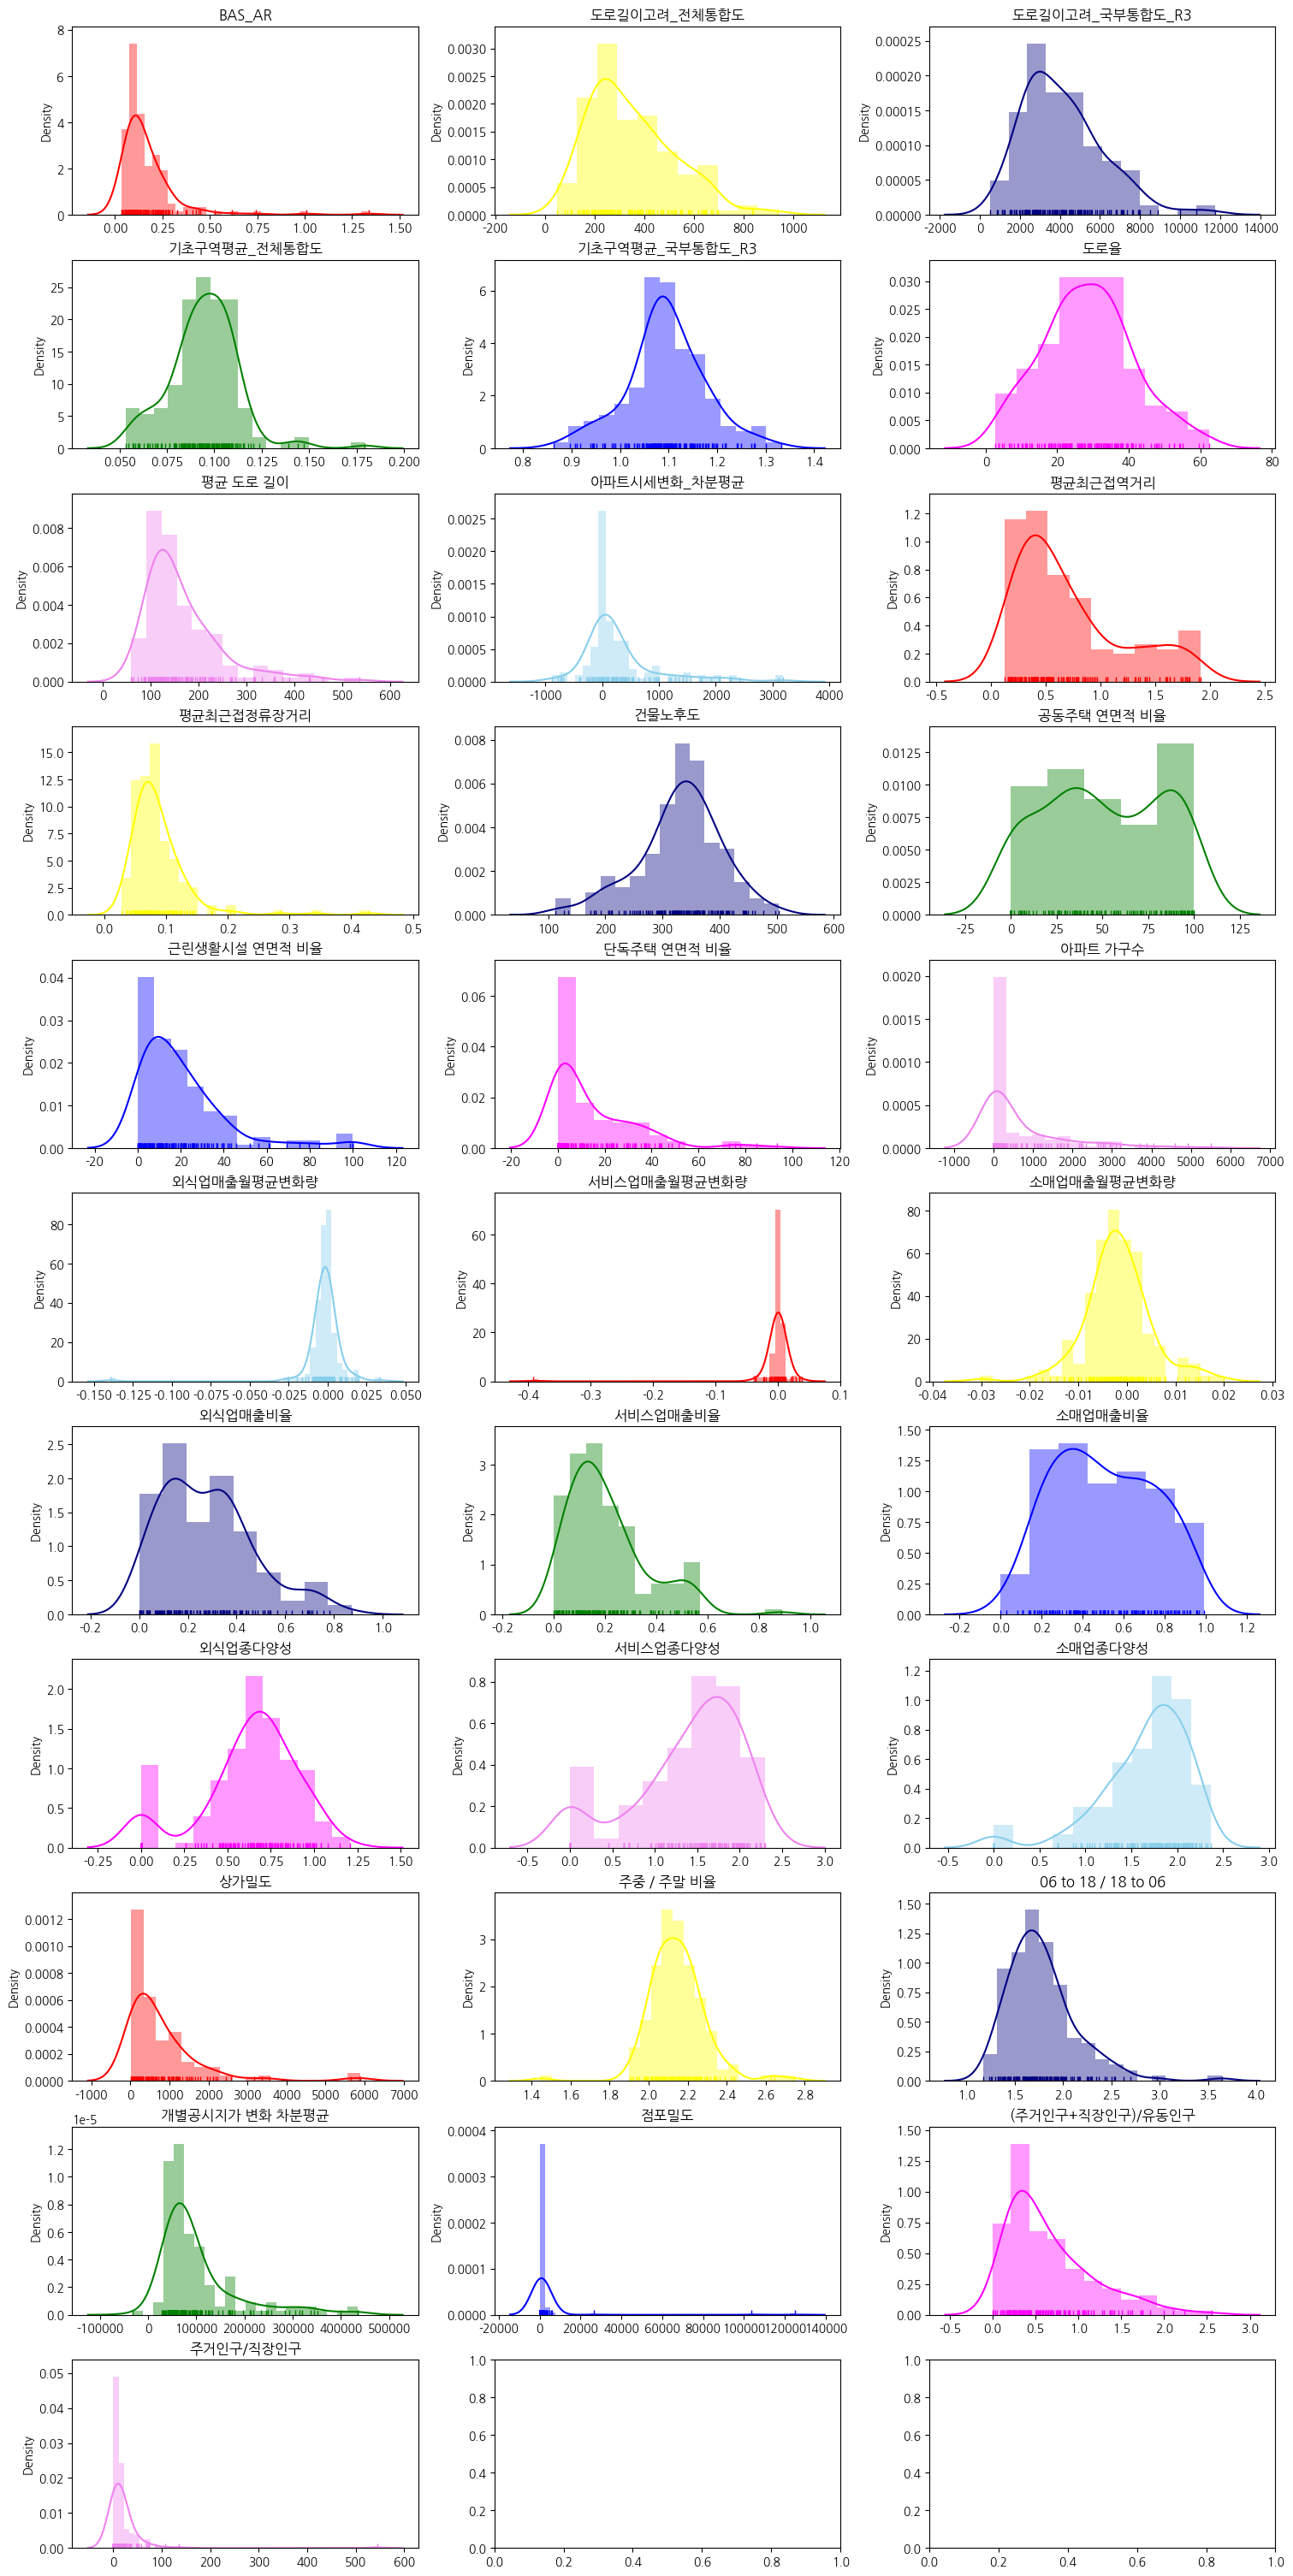

In [78]:
ind_var_col = list(range(1,9)) + list(range(11,34))
dX = clean_data.iloc[:,ind_var_col]

col_list = list(dX)
nrows = int(len(col_list)/3)+1
ncols = 3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,30),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(nrows):
    for j in range(ncols):
        if (ncols*i+j) == len(col_list):
            break
        
        sns.distplot(ax=axes[i,j], x=dX[col_list[(ncols*i+j)]], kde=True,color=color[(ncols*i+j) % len(color)],rug=True)
        axes[i,j].set_title(col_list[ncols*i+j])
         
plt.show()

# 2. 공간상관성 검증
- H0 : 군집이 존재하지 않는다. 즉, 모든 구역이 Randomness를 가진다.(AutoCorrelation이 없다.)
- 유의 수준 : 0.05
- 검정통계량 : Morans'I

In [17]:
ind_var_col = list(range(1,9)) + list(range(11,34))+[36]

gdf = clean_data.iloc[:,ind_var_col]
y = clean_data['평균폐업기간'].values

In [18]:
w = Queen.from_dataframe(gdf)
w.transform = 'r'

AttributeError: 'DataFrame' object has no attribute 'geometry'

In [19]:
# Assessing Global Spatial Autocorrelation
# calculate Morans'I. 
w = Queen.from_dataframe(gdf)
moran = Moran(y, w)
moran.I

AttributeError: 'DataFrame' object has no attribute 'geometry'

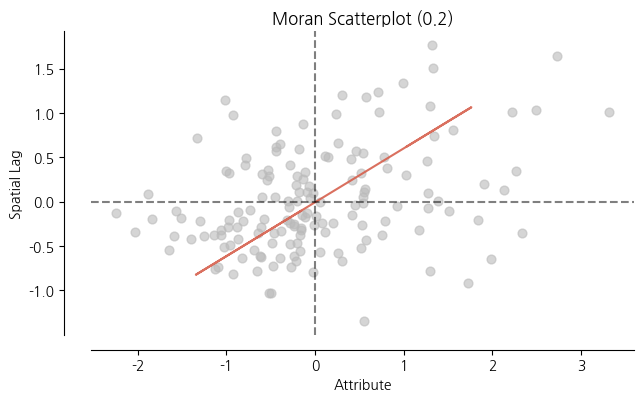

In [18]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

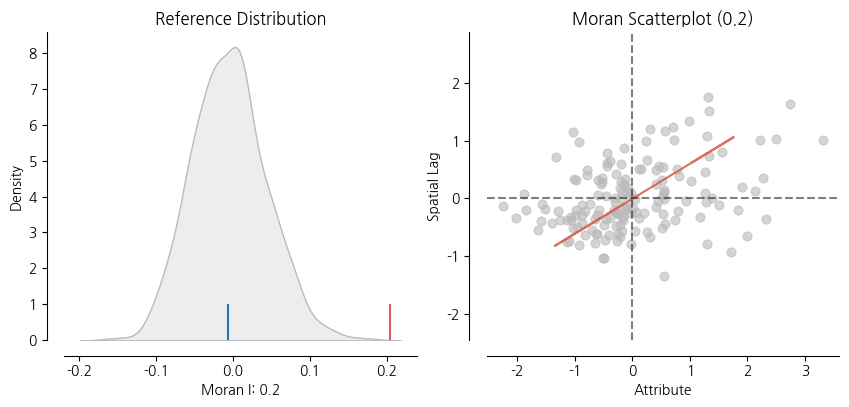

In [19]:
from splot.esda import plot_moran

plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [20]:
moran.p_sim

0.001

- p-value가 0.003이므로 유의수준 5%이내에서 전역적으로 보았을 때 군집이 존재하다고 이야기 할수 있다.

# 3. LISA 검정
- 왜 국지적 모델(GWR)을 써야하는가?
- Morans'I를 통해서 공간적 의존성은 확인할 수 있으나 공간적 이질성은 확인할 수가 없다.
- 공간적 의존성 : 공간상의 한 지점에서 측정된 현상이 다른 지점에서의 측정값과 서로 관련이 있을 때 나타난다.
- 공간적 이질성 : 각 지점이나 지역에 내재된 고유성에서 발생하게 되는 자료의 지리적 변이나 통계적 특성의 차이를 말한다.
- LISA 검정을 통해서 공간적 이질성이 존재하는지 확인해본다.
- H0 : 특정지역별로 공간적 군집이 형성되지 않는다.
- 유의 수준 : 0.05

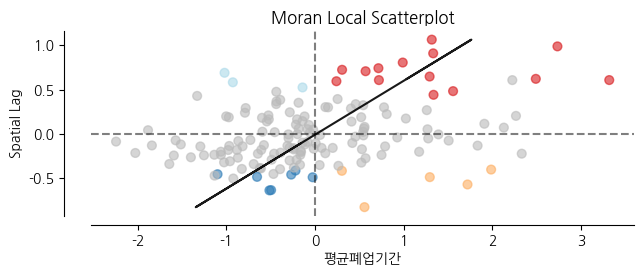

In [21]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisa = Moran_Local(y, w)
fig, ax = moran_scatterplot(lisa, p=0.05)
ax.set_xlabel('평균폐업기간')
ax.set_ylabel('Spatial Lag')
plt.show()

In [22]:
sig = lisa.p_sim < 0.05
sig.sum()

29

In [23]:
hotspots = lisa.q==1 * sig
hotspots.sum()

14

In [24]:
# HH Area
clean_data[hotspots]

,BAS_ID,BAS_AR,INT_LOAD,INT_LOAD_R3,INT_BAS,INT_BAS_R3,도로율,평균 도로 길이,APART_DIFF_AVG,평균영업기간,...,상가밀도,주중 / 주말 비율,06 to 18 / 18 to 06,BUILD_DIFF_AVG,점포밀도,(주거인구+직장인구)/유동인구,주거인구/직장인구,x,y,geometry
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.00000,152.307733,...,47.085413,2.342449,2.695669,31337.73585,1759.373944,0.303313,0.299127,126.689135,37.518708,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.90900,159.363582,...,140.443637,2.315147,2.280277,344640.00000,421.947013,0.356950,1.335893,126.695459,37.522417,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.50000,153.728003,...,7.388826,2.273528,2.246297,97041.79104,461.266314,0.201775,12.617228,126.698730,37.518981,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
5,21305,0.098059,523.710848,6145.133162,0.095792,1.100614,38.069916,106.077128,0.00000,179.564066,...,856.627133,2.048316,1.997069,69414.52880,4566.907644,0.376629,4.180348,126.703004,37.515329,"POLYGON ((126.70432 37.51753, 126.70426 37.517..."
6,21306,0.284578,649.381963,7939.781286,0.087015,1.078935,12.802792,117.955382,1753.75000,145.382862,...,66.765527,1.953813,2.429456,76053.06346,5882.780945,2.558570,49.280796,126.697205,37.515679,"POLYGON ((126.70215 37.51767, 126.70214 37.517..."
7,21307,0.616604,589.273284,7121.372418,0.089115,1.069964,6.382154,119.324019,458.70125,124.831374,...,105.416118,1.944366,2.252227,56452.17391,720.266044,1.727312,17.421429,126.693100,37.512529,"POLYGON ((126.70164 37.51321, 126.70165 37.513..."
8,21308,0.229900,421.903482,5071.581658,0.093441,1.153545,9.134493,156.407455,0.00000,171.724749,...,73.945194,2.262532,1.770196,67064.35185,406.738655,1.835686,19.015844,126.694636,37.509724,"POLYGON ((126.69275 37.51095, 126.69369 37.510..."
9,21309,0.102131,342.128741,4248.872704,0.098518,1.144899,33.748921,149.365524,1716.71400,131.415793,...,773.516366,2.146131,1.985019,77593.49776,1010.378351,0.438911,8.377488,126.702572,37.510880,"POLYGON ((126.70394 37.51300, 126.70393 37.512..."
65,21367,0.228448,433.242790,5042.136816,0.094212,1.099477,23.912363,125.875000,168.32500,177.378043,...,26.264183,2.244106,1.861148,86329.74684,164.718929,1.998314,52.758156,126.696109,37.507611,"POLYGON ((126.69990 37.50892, 126.69990 37.508..."
66,21368,0.218311,302.074763,3370.850035,0.088329,1.013514,5.180353,79.951000,-172.09800,138.682993,...,59.548076,2.227330,1.885386,98608.75000,185.571481,0.583356,15.421209,126.692740,37.505831,"POLYGON ((126.69505 37.50601, 126.69556 37.505..."


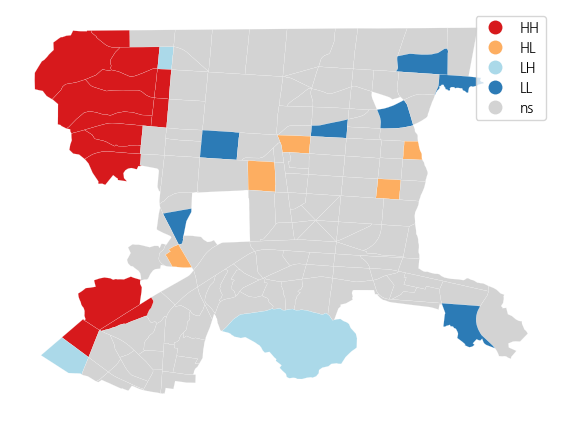

In [25]:
from splot.esda import lisa_cluster

gdf = gpd.GeoDataFrame(gdf)

lisa_cluster(lisa, gdf, p=0.05, figsize = (7,7))
plt.show()

- 총 13곳의 hotspot이 존재한다. 따라서 공간적 이질성을 가진다고 판단할 수 있고, GWR 모델을 고려해야 한다.

# 4. OLS

## 4.1 독립변수, 종속변수 설정

In [21]:
import statsmodels.api as sm

In [45]:
ind_var_col = list(range(1,9)) + list(range(11,34))

X = clean_data.iloc[:,ind_var_col].values
X = sm.add_constant(X)
y = clean_data.loc[:,'평균폐업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     3.029
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           8.25e-06
Time:                        11:41:30   Log-Likelihood:                -734.36
No. Observations:                 152   AIC:                             1533.
Df Residuals:                     120   BIC:                             1629.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.8273    167.494      0.506      0.613    -246.799     416.454
x1             7.2161     37.955      0.190      0.850     -67.931      82.363
x2             0.0172      0.093      0.185      0.854      -0.167       0.201
x3             0.0026      0.008      0.336      0.737      -0.013       0.018
x4          -181.1468    399.911     -0.453      0.651    -972.943     610.649
x5             8.1263     60.579      0.134      0.894    -111.817     128.069
x6            -0.7559      0.376     -2.010      0.047      -1.500      -0.011
x7            -0.1164      0.054     -2.152      0.033      -0.224      -0.009
x8            -0.0109      0.005     -2.358      0.020      -0.020      -0.002
x9             4.5598      8.002      0.570      0.570     -11.284      20.404
x10         -178.8577     92.858     -1.926      0.056    -362.710       4.995
x11            0.0804      0.053      1.521      0.131      -0.024       0.185
x12           -0.1273      0.199     -0.639      0.524      -0.522       0.267
x13           -0.0730      0.269     -0.272      0.786      -0.605       0.459
x14           -0.4611      0.259     -1.783      0.077      -0.973       0.051
x15           -0.0080      0.004     -2.011      0.047      -0.016      -0.000
x16          -80.9502    261.144     -0.310      0.757    -597.998     436.097
x17           69.7989    377.816      0.185      0.854    -678.250     817.848
x18         -321.8077    496.389     -0.648      0.518   -1304.623     661.008
x19           34.7254    155.278      0.224      0.823    -272.715     342.166
x20          -16.5725    156.068     -0.106      0.916    -325.576     292.431
x21           -9.9585    154.241     -0.065      0.949    -315.345     295.428
x22            1.1994     14.224      0.084      0.933     -26.963      29.362
x23          -11.5880      7.622     -1.520      0.131     -26.679       3.503
x24           -7.3285     10.369     -0.707      0.481     -27.859      13.202
x25           -0.0021      0.005     -0.434      0.665      -0.012       0.008
x26           24.1264     29.247      0.825      0.411     -33.780      82.033
x27           12.7120     15.286      0.832      0.407     -17.553      42.977
x28        -4.967e-06    5.6e-05     -0.089      0.930      -0.000       0.000
x29           -0.0002      0.000     -0.686      0.494      -0.001       0.000
x30           10.6570      7.928      1.344      0.181      -5.039      26.353
x31            0.0360      0.079      0.457      0.648      -0.120       0.192
==============================================================================
Omnibus:                        4.748   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                5.570
Skew:                           0.180   Prob(JB):                       0.0617
Ku

## 4.2 Modeling

### 4.2.1 다중공선성

In [46]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(clean_data.iloc[:,ind_var_col])
result.iloc[-20:,]

,VIF Factor,features
11,7.404839,개별공시지가 변화 차분평균
12,8.090639,근린생활시설 연면적 비율
13,9.987610,BAS_AR
14,11.213929,평균최근접정류장거리
15,12.533416,외식업종다양성
16,12.573437,평균 도로 길이
17,17.313186,서비스업종다양성
18,17.715427,도로율
19,18.646121,공동주택 연면적 비율
20,40.973642,소매업종다양성


#### 4.2.1.2 column 제거

In [47]:
dX = clean_data.iloc[:,ind_var_col]

def RFE(df):
    flag = True
    next_col = list(dX.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(dX)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['서비스업매출월평균변화량',
 '외식업매출월평균변화량',
 '아파트시세변화_차분평균',
 '소매업매출월평균변화량',
 '주거인구/직장인구',
 '점포밀도',
 '아파트 가구수',
 '단독주택 연면적 비율',
 '서비스업매출비율',
 '상가밀도',
 '외식업매출비율',
 '개별공시지가 변화 차분평균',
 '평균최근접역거리',
 '근린생활시설 연면적 비율',
 '(주거인구+직장인구)/유동인구',
 'BAS_AR',
 '도로길이고려_국부통합도_R3',
 '평균 도로 길이',
 '외식업종다양성',
 '평균최근접정류장거리',
 '공동주택 연면적 비율']

#### 4.2.1.3 Remodeling


In [48]:
X = clean_data.loc[:,optimal_feature].values
X = sm.add_constant(X)
y = clean_data.loc[:,'평균폐업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     3.126
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           3.80e-05
Time:                        11:41:52   Log-Likelihood:                -747.23
No. Observations:                 152   AIC:                             1538.
Df Residuals:                     130   BIC:                             1605.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.6326     25.255      4.975      0.000      75.669     175.596
x1            79.5847    102.468      0.777      0.439    -123.135     282.305
x2          -206.4925    252.750     -0.817      0.415    -706.527     293.542
x3            -0.0106      0.005     -2.276      0.024      -0.020      -0.001
x4          -753.6573    497.824     -1.514      0.132   -1738.542     231.228
x5             0.0020      0.075      0.027      0.978      -0.145       0.150
x6            -0.0003      0.000     -0.870      0.386      -0.001       0.000
x7            -0.0128      0.004     -3.368      0.001      -0.020      -0.005
x8            -0.4210      0.262     -1.606      0.111      -0.940       0.098
x9             7.1555     20.900      0.342      0.733     -34.192      48.503
x10           -0.0089      0.005     -1.955      0.053      -0.018       0.000
x11           44.3500     17.497      2.535      0.012       9.734      78.966
x12        -2.537e-05   5.13e-05     -0.495      0.621      -0.000     7.6e-05
x13            7.8269      7.380      1.061      0.291      -6.774      22.427
x14           -0.0947      0.264     -0.359      0.720      -0.617       0.428
x15            9.4945      7.998      1.187      0.237      -6.328      25.317
x16           47.4618     30.271      1.568      0.119     -12.426     107.350
x17            0.0027      0.002      1.555      0.122      -0.001       0.006
x18           -0.1184      0.046     -2.579      0.011      -0.209      -0.028
x19          -14.6769     13.336     -1.101      0.273     -41.061      11.708
x20         -133.9588     87.426     -1.532      0.128    -306.921      39.003
x21           -0.0572      0.203     -0.282      0.778      -0.458       0.344
==============================================================================
Omnibus:                        3.122   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.681
Skew:                           0.310   Prob(JB):                        0.262
Kurtosis:                       3.200   Cond. No.                     2.33e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2.2 잔차분석
- 회귀모형에 대한 가정(정규성, 등분산성, 독립성)을 충족하는지에 대한 검정, 이상치가 개입하는지에 대한 검정을 하는 절차

In [31]:
import scipy as sp
from scipy import stats

#### 4.2.2.1 잔차 정규성

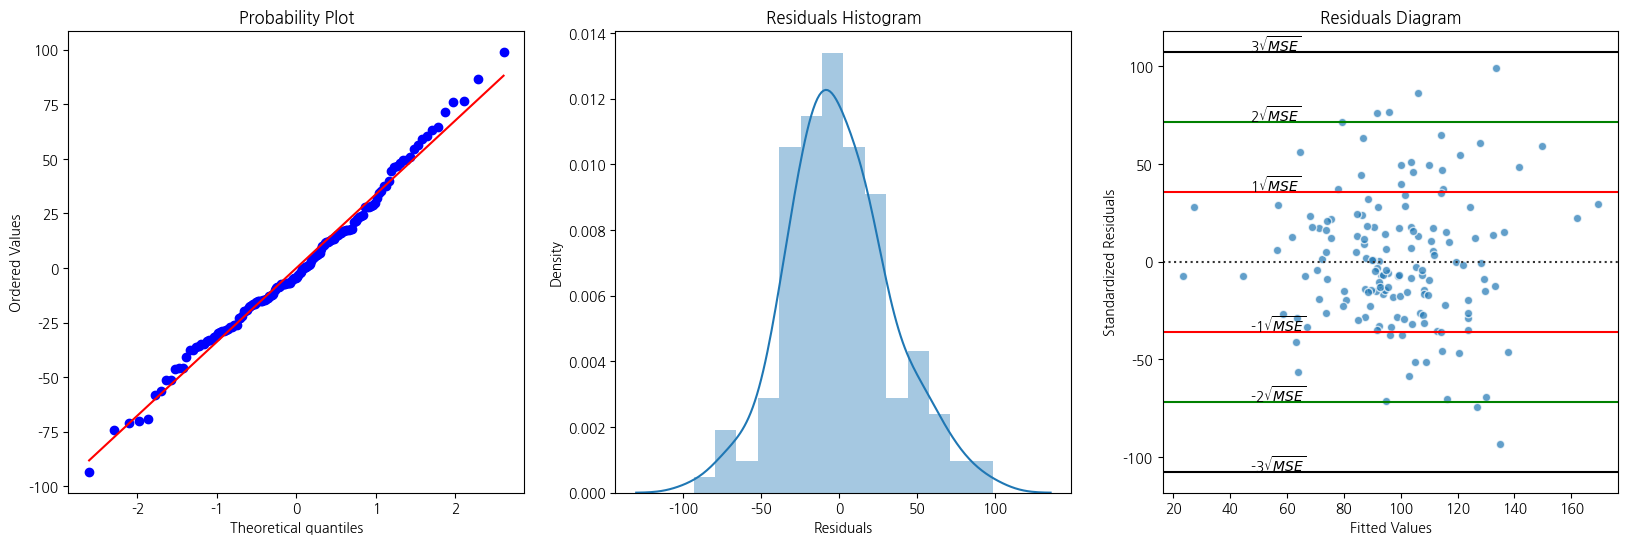

In [32]:
figure, axs = plt.subplots(1,3, figsize = (20,6))

# 잔차 Q-Q  plot
# sm.ProbPlot(fit1.resid).qqplot(line="s",ax=axs[0])
sp.stats.probplot(results.resid, dist='norm', fit=True, plot=axs[0])

# 잔차의 히스토그램
sns.distplot(x = results.resid , ax = axs[1])
axs[1].set_xlabel("Residuals")
axs[1].set_title("Residuals Histogram")

# 잔차도 MSE 라인
yhat = pd.DataFrame(results.fittedvalues)
temp = pd.concat([yhat,clean_data.loc[:,'평균폐업기간']],axis=1)
temp.columns = ['yhat','MEDV']

sns.residplot(x='yhat',y='MEDV',data=temp, scatter_kws = {'edgecolor':"white", "alpha":0.7}, line_kws = {"color":"red"})
MSE_sq = np.sqrt(results.mse_resid) #RMSE

# 잔차도 MSE line
for i, c in enumerate(["red", "green", "black"]):
    axs[2].axhline( (i+1) * MSE_sq, color = c)
    axs[2].axhline( -(i+1) * MSE_sq, color = c)
    
    axs[2].text(47, (i+1) * MSE_sq, f"{i+1}"r'${}\sqrt{MSE}$')
    axs[2].text(47, -(i+1) * MSE_sq, f"-{i+1}"r'${}\sqrt{MSE}$')

axs[2].set_xlabel("Fitted Values")
axs[2].set_ylabel("Standardized Residuals")
axs[2].set_title("Residuals Diagram")

plt.show()

In [33]:
test = stats.shapiro(results.resid)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 유의수준 0.05에서 귀무가설을 기각하고 대립가설 채택
# 따라서 정규성을 띄지 않는다고 말할 수 있다.

검정통계량 : 0.9899351000785828
p-value : 0.3504577577114105


#### 4.2.2.2 잔차 등분산성
- 종속 변수의 값의 분산이 독립 변수의 값과 상관없이 고정된 값을 가져야 한다.
- 실제 데이터는 독립 변수 값의 크기가 커지면 종속 변수 값의 분산도 커지는 이분산성 문제가 발생한다.

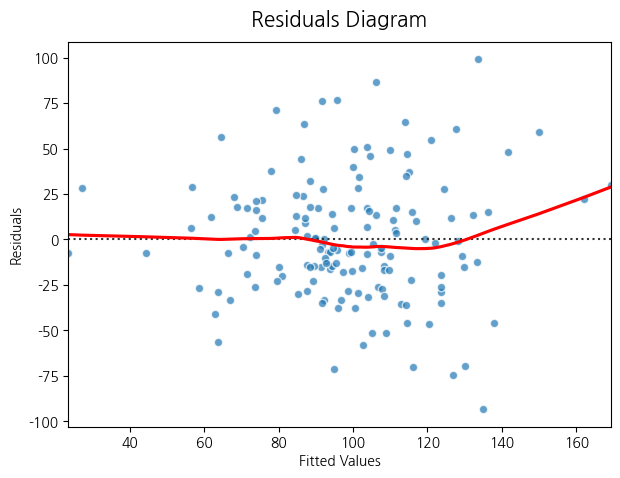

In [34]:
fig = plt.figure(figsize= (7,5))

p = sns.residplot(x = "yhat", y = "MEDV", 
                  data = temp, 
                  scatter_kws = {'edgecolor':"white", "alpha":0.7},
                  lowess = True,
              line_kws = {"color":"red"})

p.set_title("Residuals Diagram", fontsize=15, y=1.02)
p.set(xlabel= "Fitted Values", ylabel = "Residuals")

plt.show()

In [35]:
from sklearn.linear_model import LinearRegression
from scipy.stats import chisqprob


def breusch_pagan_test(x, y):
    '''
    Breusch-Pagan test for heteroskedasticity in a linear regression model:
    H_0 = No heteroskedasticity.
    H_1 = Heteroskedasticity is present.

    Inputs:
    x = a numpy.ndarray containing the predictor variables. Shape = (nSamples, nPredictors).
    y = a 1D numpy.ndarray containing the response variable. Shape = (nSamples, ).

    Outputs a list containing three elements:
    1. the Breusch-Pagan test statistic.
    2. the p-value for the test.
    3. the test result.
    '''

    if y.ndim != 1:
        raise SystemExit('Error: y has more than 1 dimension.')
    if x.shape[0] != y.shape[0]:
        raise SystemExit('Error: the number of samples differs between x and y.')
    else:
        n_samples = y.shape[0]

    # fit an OLS linear model to y using x:
    lm = LinearRegression()
    lm.fit(x, y)

    # calculate the squared errors:
    err = (y - lm.predict(x))**2

    # fit an auxiliary regression to the squared errors:
    # why?: to estimate the variance in err explained by x
    lm.fit(x, err)
    pred_err = lm.predict(x)
    del lm

    # calculate the coefficient of determination:
    ss_tot = sum((err - np.mean(err))**2)
    ss_res = sum((err - pred_err)**2)
    r2 = 1 - (ss_res / ss_tot)
    del err, pred_err, ss_res, ss_tot

    # calculate the Lagrange multiplier:
    LM = n_samples * r2
    del r2

    # calculate p-value. degrees of freedom = number of predictors.
    # this is equivalent to (p - 1) parameter restrictions in Wikipedia entry.
    pval = chisqprob(LM, x.shape[1])

    if pval < 0.01:
        test_result = 'Heteroskedasticity present at 99% CI.'
    elif pval < 0.05:
        test_result = 'Heteroskedasticity present at 95% CI.'
    else:
        test_result = 'No significant heteroskedasticity.'
    return [LM, pval, test_result]

tX = clean_data.iloc[:,ind_var_col]
ty = X = clean_data.loc[:,'평균영업기간']

result = breusch_pagan_test(tX,ty)
print('LM : {}\np-value : {}\ntest_result {}'.format(result[0],result[1],result[2]))

# p-value가 0.05보다 크므로 귀무가설을 기각할 수 없다. 따라서 등분산성을 만족한다고 할수 있다.

LM : 28.038247796727106
p-value : 0.6191897258369915
test_result No significant heteroskedasticity.


#### 4.2.2.3 잔차 독립성

In [36]:
from statsmodels.stats.stattools import durbin_watson

print(f"D-W 통계량: {round(durbin_watson(results.resid),3)}")

# 통계량이 1.5~2.5 사이이므로 잔차들이 자기상관성을 가지고 있지 않다. 따라서 독립성을 만족한다.

D-W 통계량: 1.922


### 4.2.3 PCA

In [37]:
# Scaling
dX_scaled = StandardScaler().fit_transform(dX.values)
std_df = pd.DataFrame(dX_scaled, index=dX.index, columns=dX.columns)

# PCA
pca = PCA(n_components=len(dX.columns))
pca_array = pca.fit_transform(std_df)
pca_df = pd.DataFrame(pca_array, index=dX.index,
                      columns=[f"pca{num+1}" for num in range(dX.shape[1])])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,...,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31
0,4.134855,3.355482,-2.346641,-1.977495,0.415971,-1.460871,-1.461123,-0.573153,-0.770884,-0.782605,...,0.979596,0.569463,0.195272,0.302263,-0.558546,0.898773,-0.517584,-0.159045,0.022575,1.223574e-09
1,3.705083,0.581207,-1.234199,0.933993,-1.660951,-2.042338,1.659735,-2.184614,-0.999568,-2.056817,...,-0.176838,-1.306091,-0.818475,0.218238,0.308849,-0.560785,-0.844032,-0.097569,-0.014629,-2.369269e-09
2,0.588021,0.682244,-0.204778,-0.072680,0.491718,-2.197209,0.671707,-0.017174,-1.383340,-0.034498,...,0.101809,0.203724,0.902263,0.465320,0.809875,-0.299140,0.387408,-0.090489,-0.057751,-1.852288e-09
3,2.711145,1.558823,-4.248424,-1.546832,0.536495,1.845385,0.541935,-1.242760,0.675761,-1.630705,...,0.126878,-1.043740,0.861671,-0.854506,-0.169764,-0.340426,-0.134496,-0.065767,0.069432,1.937225e-09
4,-1.750628,0.659904,-1.303227,-0.351237,0.273101,0.991399,1.432878,0.905133,-1.017263,-0.797362,...,0.304357,-0.046856,0.161605,0.292160,-0.017675,-0.352722,-0.014576,0.092131,0.046997,-4.867296e-09


In [38]:
# 고윳값과 누적기여율 계산

result = pd.DataFrame({'고윳값':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(dX.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,고윳값,기여율,누적기여율
pca1,5.146008e+00,1.649082e-01,0.164908
pca2,3.806625e+00,1.219865e-01,0.286895
pca3,3.024539e+00,9.692391e-02,0.383819
pca4,2.705681e+00,8.670582e-02,0.470524
pca5,2.235454e+00,7.163699e-02,0.542161
pca6,1.710702e+00,5.482089e-02,0.596982
pca7,1.518481e+00,4.866101e-02,0.645643
pca8,1.329583e+00,4.260761e-02,0.688251
pca9,1.275218e+00,4.086543e-02,0.729116
pca10,1.089551e+00,3.491556e-02,0.764032


In [39]:
# 개별 고윳값 즉, 각 주성분 마다 고윳값이 0.7이상인 주성분들, 누적기여율이 80% 이상이 넘어거지는 지점까지의 
# 주성분들을 기준으로 하여 적절한 주성분 개수를 설정한다. 

condition = (result['고윳값'] >= 0.7) & (result['누적기여율'] >= 0.8)
pca_index = list(result[condition].reset_index().index)

In [40]:
pca_columns = list(dX.iloc[:,pca_index].columns)
pca_columns

['BAS_AR', 'INT_LOAD']

In [41]:
X = dX.loc[:,pca_columns].values

In [42]:
#Calibrate GWR model
# 평균영업기간

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.739
Model:                            OLS   Adj. R-squared (uncentered):              0.735
Method:                 Least Squares   F-statistic:                              212.2
Date:                Wed, 03 Nov 2021   Prob (F-statistic):                    1.84e-44
Time:                        14:10:30   Log-Likelihood:                         -822.89
No. Observations:                 152   AIC:                                      1650.
Df Residuals:                     150   BIC:                                      1656.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            61.6210     28.800      2.140      0.034       4.715     118.527
x2             0.2062      0.017     11.920      0.000       0.172       0.240
==============================================================================
Omnibus:                        0.740   Durbin-Watson:                   1.318
Prob(Omnibus):                  0.691   Jarque-Bera (JB):                0.407
Skew:                           0.082   Prob(JB):                        0.816
Kurtosis:                       3.194   Cond. No.                     2.52e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 4.2.3.1 Remodeling
- 이번에는 다중공선성을 제거했을 때 OLS에서 통계적으로 관련이 없는 column들을 제거해보고 돌려보자.

In [43]:
use_col = [0,8,9,10,12,15,16,17]

remove_low_pvalue = dX.iloc[:,use_col]
X = remove_low_pvalue.values

In [44]:
#Calibrate GWR model
# 평균영업기간

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.868
Method:                 Least Squares   F-statistic:                              126.1
Date:                Wed, 03 Nov 2021   Prob (F-statistic):                    4.14e-61
Time:                        14:10:30   Log-Likelihood:                         -766.86
No. Observations:                 152   AIC:                                      1550.
Df Residuals:                     144   BIC:                                      1574.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            71.2959     30.527      2.336      0.021      10.957     131.634
x2             6.6643      7.127      0.935      0.351      -7.423      20.752
x3           -60.5958     79.839     -0.759      0.449    -218.404      97.213
x4             0.2643      0.021     12.440      0.000       0.222       0.306
x5             0.0205      0.156      0.132      0.895      -0.287       0.328
x6         -6.261e-09   1.28e-08     -0.491      0.624   -3.15e-08    1.89e-08
x7          5.199e-11   9.75e-09      0.005      0.996   -1.92e-08    1.93e-08
x8         -6.081e-08   8.99e-08     -0.677      0.500   -2.38e-07    1.17e-07
==============================================================================
Omnibus:                        6.797   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                7.536
Skew:                           0.335   Prob(JB):                       0.0231
Kurtosis:                       3.860   Cond. No.                     7.42e+10
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 7.42e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2.4 교차 검증

In [45]:
# 필요한 모듈 import
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [46]:
# 다중공선성이 있는 column들을 제거한 독립변수들을 사용함

train_scores = np.zeros(5)
test_scores = np.zeros(5)
train_rmse = np.zeros(5)
test_rmse = np.zeros(5)


cv = KFold(5, shuffle=True, random_state=0)

for i, (idx_train, idx_test) in enumerate(cv.split(X = X, y = y)):
    local_X_train, local_y_train = X[idx_train], y[idx_train]
    local_X_test, local_y_test = X[idx_test], y[idx_test]
    
    model = sm.OLS(local_y_train,local_X_train)
    result = model.fit()
    
    pred = result.predict(local_X_test)
    
    train_scores[i] = result.rsquared
    test_scores[i] = r2_score(local_y_test,pred)
    train_rmse[i] = np.sqrt(result.mse_model)
    test_rmse[i] = np.sqrt(mean_squared_error(local_y_test,pred))
    
    print('====================== FOLD {} ======================'.format(i))
    print('학습 RMSE : {:.8f}, 검증 RMSE : {:.8f}'.format(np.sqrt(result.mse_model),test_rmse[i]))
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, test_scores[i]))
    
print('\n===================== 평균 결과 ======================')
print('학습 평균 R2 : {:.8f}   검증 평균 R2 : {:.8f}'.format(train_scores.mean(),test_scores.mean()))
print('학습 평균 RMSE : {:.8f}   검증 평균 RMSE : {:.8f}'.format(train_rmse.mean(), test_rmse.mean()))

====================== FOLD 0 ======================
학습 RMSE : 388.03459511, 검증 RMSE : 50.33736219
학습 R2 = 0.88118374, 검증 R2 = -0.71792813
====================== FOLD 1 ======================
학습 RMSE : 389.63226120, 검증 RMSE : 25.49214877
학습 R2 = 0.86188401, 검증 R2 = 0.15504690
====================== FOLD 2 ======================
학습 RMSE : 389.99107270, 검증 RMSE : 44.39717986
학습 R2 = 0.88181461, 검증 R2 = 0.02165313
====================== FOLD 3 ======================
학습 RMSE : 388.22712900, 검증 RMSE : 95.04404117
학습 R2 = 0.87611800, 검증 R2 = -4.70865407
====================== FOLD 4 ======================
학습 RMSE : 387.21160621, 검증 RMSE : 52.52892092
학습 R2 = 0.89727245, 검증 R2 = -0.16264367

===================== 평균 결과 ======================
학습 평균 R2 : 0.87965456   검증 평균 R2 : -1.08250517
학습 평균 RMSE : 388.61933285   검증 평균 RMSE : 53.55993058


In [47]:
# 다중공선성이 있는 column들을 제거한 독립변수들을 사용함.

lr = LinearRegression()

kfold = KFold(n_splits=5, shuffle=True, random_state=140)
score = cross_val_score(lr, X, y, cv=kfold,scoring='r2')
print('교차 검증 점수 : ', score)
print('교차 검증 평균 점수 : ', score.mean())

교차 검증 점수 :  [ 2.13134158e-01 -6.26666000e+00 -7.46258304e-02 -1.71498541e-02
 -1.90620974e-04]
교차 검증 평균 점수 :  -1.2290984286184317


# 5. XGBoost

## 5.1 교차검증

In [48]:
# test & train set 분리
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size = 0.2,random_state = 1010)

In [49]:
# XGBoost 모델에 쓰일 parameter 정의
n_splits= 5
NUM_BOOST_ROUND = 10000
SEED = 1993 
xgb_params={ 'booster':'gblinear',
         'verbosity':0,
         'silent':1,
         'num_boost_rounds':160,
         'min_child_weight':1,
         'max_depth':4,
         'early_stopping_rounds':50,
         'eta':0.1,
         'sub_sample':1,
         'eval_metric':'rmse',
}

In [50]:
# 다중공선성이 있는 column들을 제거한 독립변수들을 사용함
# OOF 방법을 사용함.

xgb_oof_train = np.zeros((X_train.shape[0],))
xgb_oof_test = np.zeros((X_test.shape[0],))

cv_list=[]

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1010, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = X_train, y = y_train ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train_f , y_train_f = X_train[trn_ind], y_train[trn_ind]
    X_valid , y_valid = X_train[val_ind], y_train[val_ind]
    
    # XGBoost
    print("---TRAINING XGBOOST--")
    dtrain = xgb.DMatrix(X_train_f,y_train_f)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    
    # model 정의 & 학습
    xgb_model = xgb.train(xgb_params,dtrain, NUM_BOOST_ROUND,
                     evals=[(dtrain,'train'),(dvalid,'valid')],
                        early_stopping_rounds=100,
                         verbose_eval=30)
    
    xgb_valid_pred = xgb_model.predict(dvalid)
    xgb_test_pred = xgb_model.predict(xgb.DMatrix(X_test,y_test))    
    
    cv_list.append(np.sqrt(mean_squared_error(y_valid,xgb_valid_pred)))
    
    xgb_oof_train[val_ind] = xgb_valid_pred
    xgb_oof_test += xgb_test_pred/n_splits
    print('='*80)

print(f"<LOCAL_TRAIN> OVERALL RMSE : {np.sqrt( mean_squared_error( y_train, xgb_oof_train ) )}")
print(f"<LOCAL_TEST>  OVERALL RMSE : {np.sqrt( mean_squared_error( y_test, xgb_oof_test ) )}")
print(f"<LOCAL_TRAIN> OVERALL R2 : {r2_score( y_train, xgb_oof_train ) }")
print(f"<LOCAL_TEST>  OVERALL R2 : {r2_score( y_test, xgb_oof_test ) }")

0it [00:00, ?it/s]

---TRAINING XGBOOST--
[0]	train-rmse:70.54211	valid-rmse:81.37912
[30]	train-rmse:38.28445	valid-rmse:44.05213
[60]	train-rmse:37.47463	valid-rmse:42.42615
[90]	train-rmse:37.25547	valid-rmse:41.66466
[120]	train-rmse:37.14499	valid-rmse:41.23609
[150]	train-rmse:37.07583	valid-rmse:40.96490
[180]	train-rmse:37.03001	valid-rmse:40.78407
[210]	train-rmse:36.99833	valid-rmse:40.66011
[240]	train-rmse:36.97599	valid-rmse:40.57222
[270]	train-rmse:36.95987	valid-rmse:40.50610
[300]	train-rmse:36.94786	valid-rmse:40.45682
[330]	train-rmse:36.93879	valid-rmse:40.41898
[360]	train-rmse:36.93175	valid-rmse:40.38871
[390]	train-rmse:36.92619	valid-rmse:40.36464
[420]	train-rmse:36.92170	valid-rmse:40.34499
[450]	train-rmse:36.91801	valid-rmse:40.32809
[480]	train-rmse:36.91494	valid-rmse:40.31383
[510]	train-rmse:36.91234	valid-rmse:40.30202
[540]	train-rmse:36.91013	valid-rmse:40.29151
[570]	train-rmse:36.90821	valid-rmse:40.28215
[600]	train-rmse:36.90656	valid-rmse:40.27411
[630]	train-rmse:

# 5. 지리가중회귀분석(GWR)

## 5.1 독립변수, 종속변수 설정

In [97]:
ind_var_col = list(range(1,9)) + list(range(11,34))

s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2
# s_X = clean_data.loc[:,optimal_feature].values
s_X = clean_data.iloc[:,ind_var_col].values
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

(152, 31)

### 5.2.1 종속변수 분포 확인


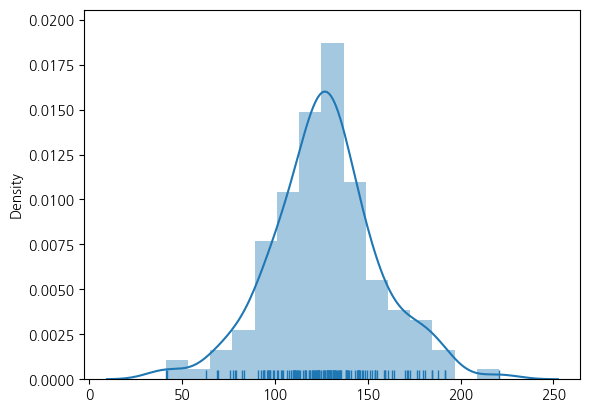

In [52]:
sns.distplot(s_y1,hist=True,kde=True,rug=True)
plt.show()

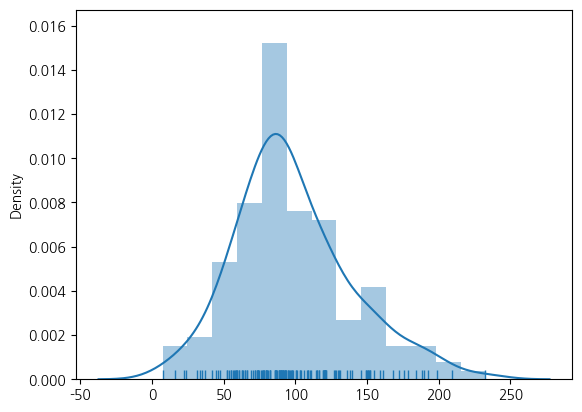

In [53]:
sns.distplot(s_y2,hist=True,kde=True,rug=True)
plt.show()

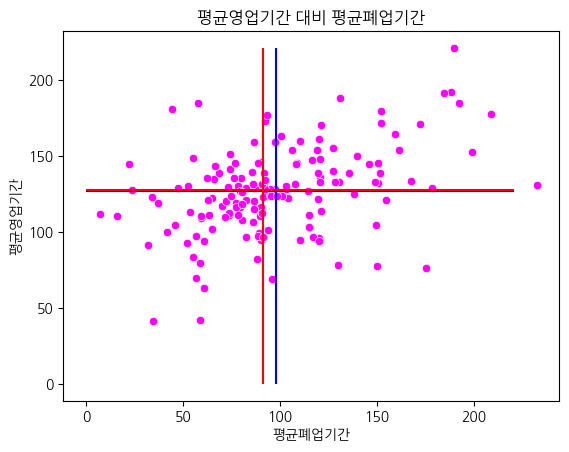

In [54]:
sns.scatterplot(data=clean_data,x='평균폐업기간',y='평균영업기간',color='magenta',palette='deep')
plt.title('평균영업기간 대비 평균폐업기간')
plt.hlines(clean_data['평균영업기간'].mean(),0,clean_data['평균영업기간'].max(),color='blue')
plt.vlines(clean_data['평균폐업기간'].mean(),0,clean_data['평균영업기간'].max(),color='blue')
plt.hlines(clean_data['평균영업기간'].median(),0,clean_data['평균영업기간'].max(),color='red')
plt.vlines(clean_data['평균폐업기간'].median(),0,clean_data['평균영업기간'].max(),color='red')
plt.show()

In [55]:
display(clean_data['평균영업기간'].agg(['mean','median']))
display(clean_data['평균폐업기간'].agg(['mean','median']))

# 평균폐업기간의 경우 중앙값이 더 작다.

mean      126.986881
median    127.664598
Name: 평균영업기간, dtype: float64

mean      98.270406
median    91.500565
Name: 평균폐업기간, dtype: float64

### 5.2.2 상권변화 유형

In [56]:
kind_area = clean_data.copy()

In [57]:
avg_open_period = kind_area['평균영업기간']
avg_close_period = kind_area['평균폐업기간']

# 각 기간의 평균 저장
open_mean = avg_open_period.median()
close_mean = avg_close_period.median()

# kind column 생성
kind_area['KIND'] = ''

# HH : 정체형, 창업 진출입시 세심한 주의 상권
HH = clean_data[(open_mean < avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'HH'

# HL : 상권축소형, 경쟁력 있는 기존 업체 우위 상권
HL = clean_data[(open_mean < avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'HL'

# LH : 상권확장형, 경쟁력 있는 신규 창업 우위 상권
LH = clean_data[(open_mean > avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'LH'

# LL : 다이나믹(순환)형, 도시재생 및 신규 개발상권으로 창업 진출입시 세심한 주의 상권
LL = clean_data[(open_mean > avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'LL'

kind_list = [HH,HL,LH,LL]
title_list = ['HH','HL','LH','LL']

In [58]:
kind_area.to_csv('../data/전처리 파일/부평구 상권변화 유형.csv',index=False,encoding='euc-kr')

In [59]:
print(('='*15)+' 상권변화 유형별 갯수 '+('='*15))
print('HH : {0}\nHL : {1}\nLH : {2}\nLL : {3}'.format(len(HH),len(HL),len(LH),len(LL)))

=============== 상권변화 유형별 갯수 ===============
HH : 51
HL : 25
LH : 25
LL : 51


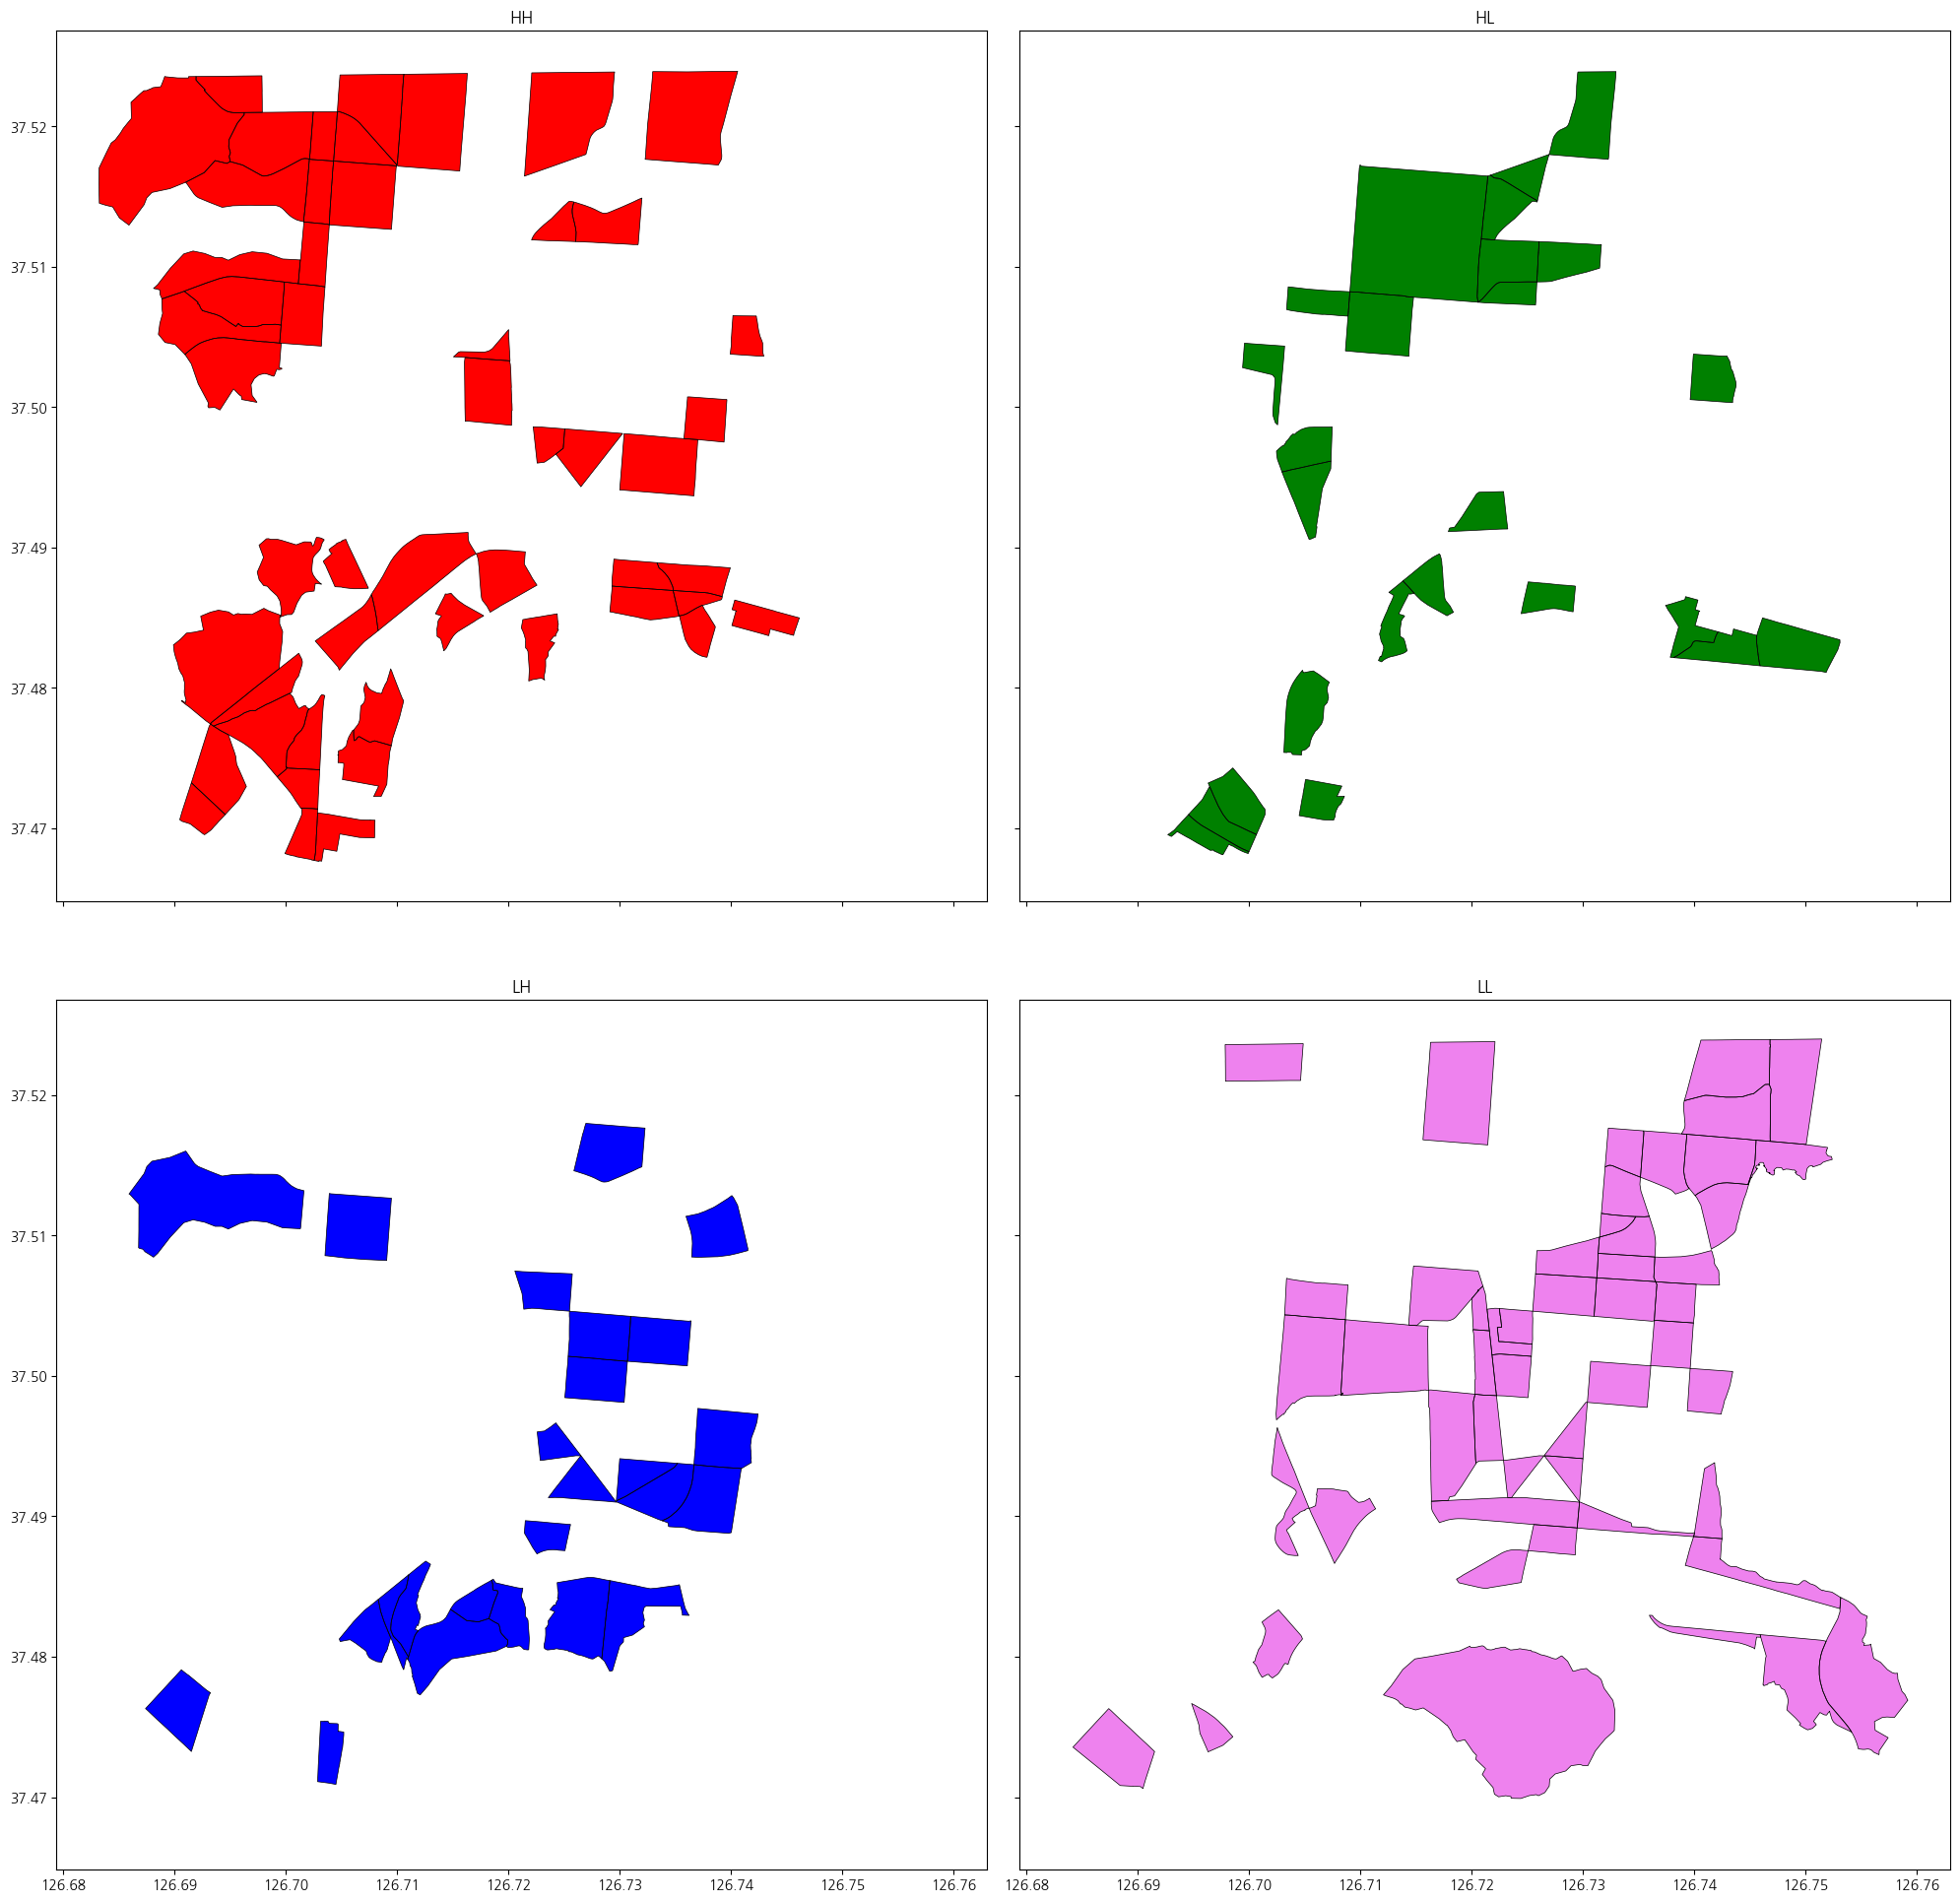

In [60]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,20))
colors = ['red','green','blue','violet']
#         HH, HL, LH, LL

for i in range(int(len(kind_list)/2)):
    for j in range(2):
        gdf = gpd.GeoDataFrame(kind_list[2*i+j])
        gdf.plot(ax=axes[i,j],color=colors[2*i+j])
        gdf.boundary.plot(ax=axes[i,j],color='black',linewidth=0.5)
        axes[i,j].set_title(title_list[2*i+j])

plt.tight_layout()
plt.show()

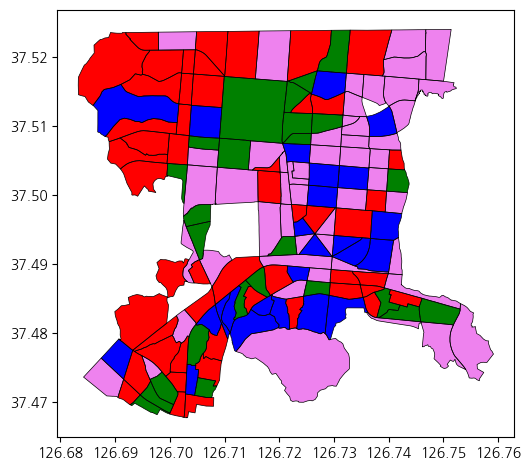

In [61]:
ax = plt.subplot()
colors = ['red','green','blue','violet']
#         HH, HL, LH, LL

for i in range(4):
    gdf = gpd.GeoDataFrame(kind_list[i])
    gdf.plot(ax=ax,color=colors[i])
    gdf.boundary.plot(ax=ax,color='black',linewidth=0.5)

plt.tight_layout()
plt.show()

## 5.2 MODELING

In [100]:
# Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

151.0


In [63]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+optimal_feature
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균폐업기간,BEST,1102).csv',index=False)

In [101]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 152
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         139901.264
Log-likelihood:                                                    -734.364
AIC:                                                               1532.729
AICc:                                                              1553.746
BIC:                                                             139298.398
R2:                                                                   0.439
Adj. R2:                                                              0.294

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5.2.1 Scaling

#### 5.2.1.1 왜도, 첨도 확인

In [79]:
from scipy.stats import skew

skew_val = []
# kurtosis_val = []

for i, col in enumerate(list(dX)):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    skew_val.append(skew(dX.loc[:,col]))
#     kurtosis_val.append(kurtosis(dX.loc[:,col],fisher=True))

skew_data = pd.DataFrame({'column name': list(dX),'skew':skew_val})
# kurtosis_data = pd.DataFrame({'column name':list(dX),'kurtosis':kurtosis_val})

In [80]:
skew_col = skew_data[skew_data['skew'].apply(lambda x : abs(x)) > 2]['column name']
# kurtosis_col = kurtosis_data[kurtosis_data['kurtosis'].apply(lambda x : abs(x)) > 3]['column name']

# skew_col
skew_col = skew_col.values

# kurtosis_col
# kurtosis_col = kurtosis_col.values
# 이 데이터들의 분포를 살펴보자.

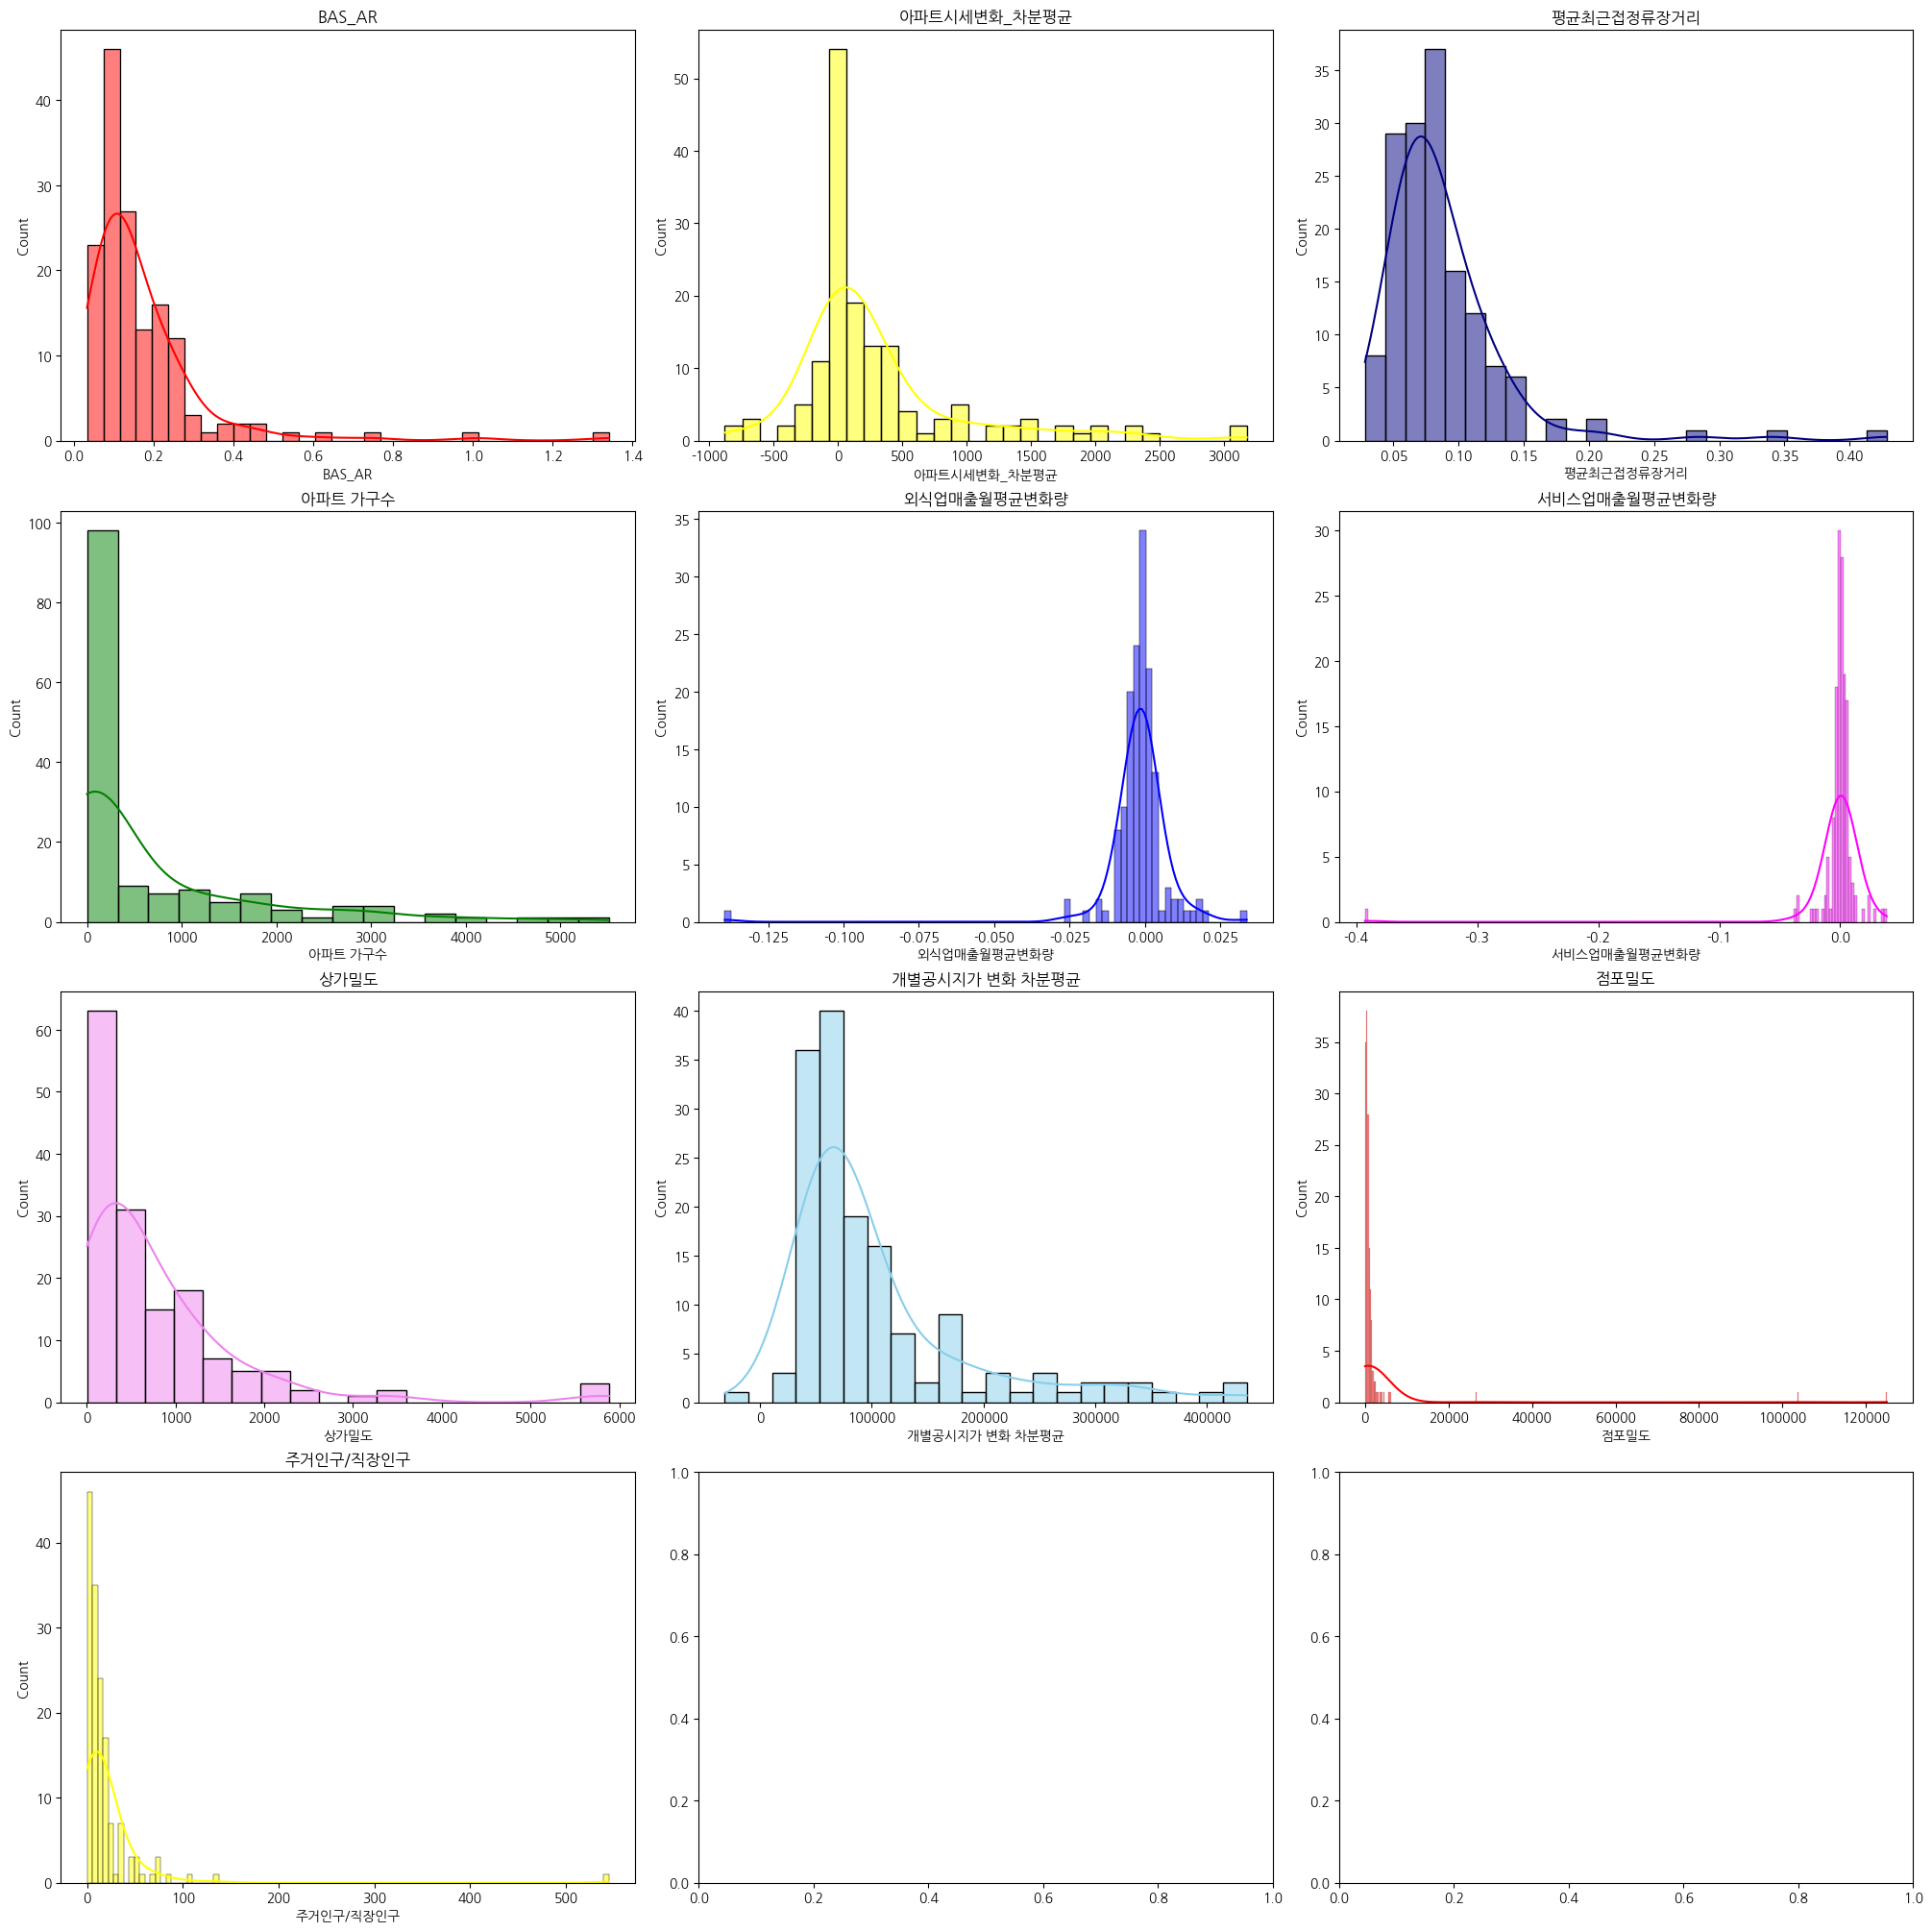

In [81]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,20),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
         
plt.show()

In [82]:
# 해당 컬럼들은 log변환 진행.

# skew = 2, kurtosis=3
log_ok_col = skew_col[[0,2,3,6,7,8]]
# robust_ok_col = diff

# skew = 3 일때
# log_ok_col = skew_col[[0,1,3,4,5,6,9,11,12]]

scaled_dX = dX.copy()
scaled_dX.loc[:,log_ok_col] = scaled_dX.loc[:,log_ok_col].apply(lambda x : np.log1p(x))
# scaled_dX.loc[:,robust_ok_col] = RobustScaler().fit_transform(scaled_dX.loc[:,robust_ok_col])

In [83]:
scaled_skew = []

for i, col in enumerate(list(log_ok_col)):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    scaled_skew.append(skew(scaled_dX.loc[:,col]))
#     kurtosis_val.append(kurtosis(dX.loc[:,col],fisher=True))

scaled_skew_data = pd.DataFrame({'column name': log_ok_col,'skew':scaled_skew})

display(skew_data[skew_data['column name'].isin(log_ok_col)])
display(scaled_skew_data)

,column name,skew
0,BAS_AR,4.127395
9,평균최근접정류장거리,3.632638
14,아파트 가구수,2.100923
24,상가밀도,2.964990
27,개별공시지가 변화 차분평균,2.017636
28,점포밀도,8.317659


,column name,skew
0,BAS_AR,3.042848
1,평균최근접정류장거리,3.188317
2,아파트 가구수,-0.006490
3,상가밀도,-0.449712
4,개별공시지가 변화 차분평균,NaN
5,점포밀도,0.564270


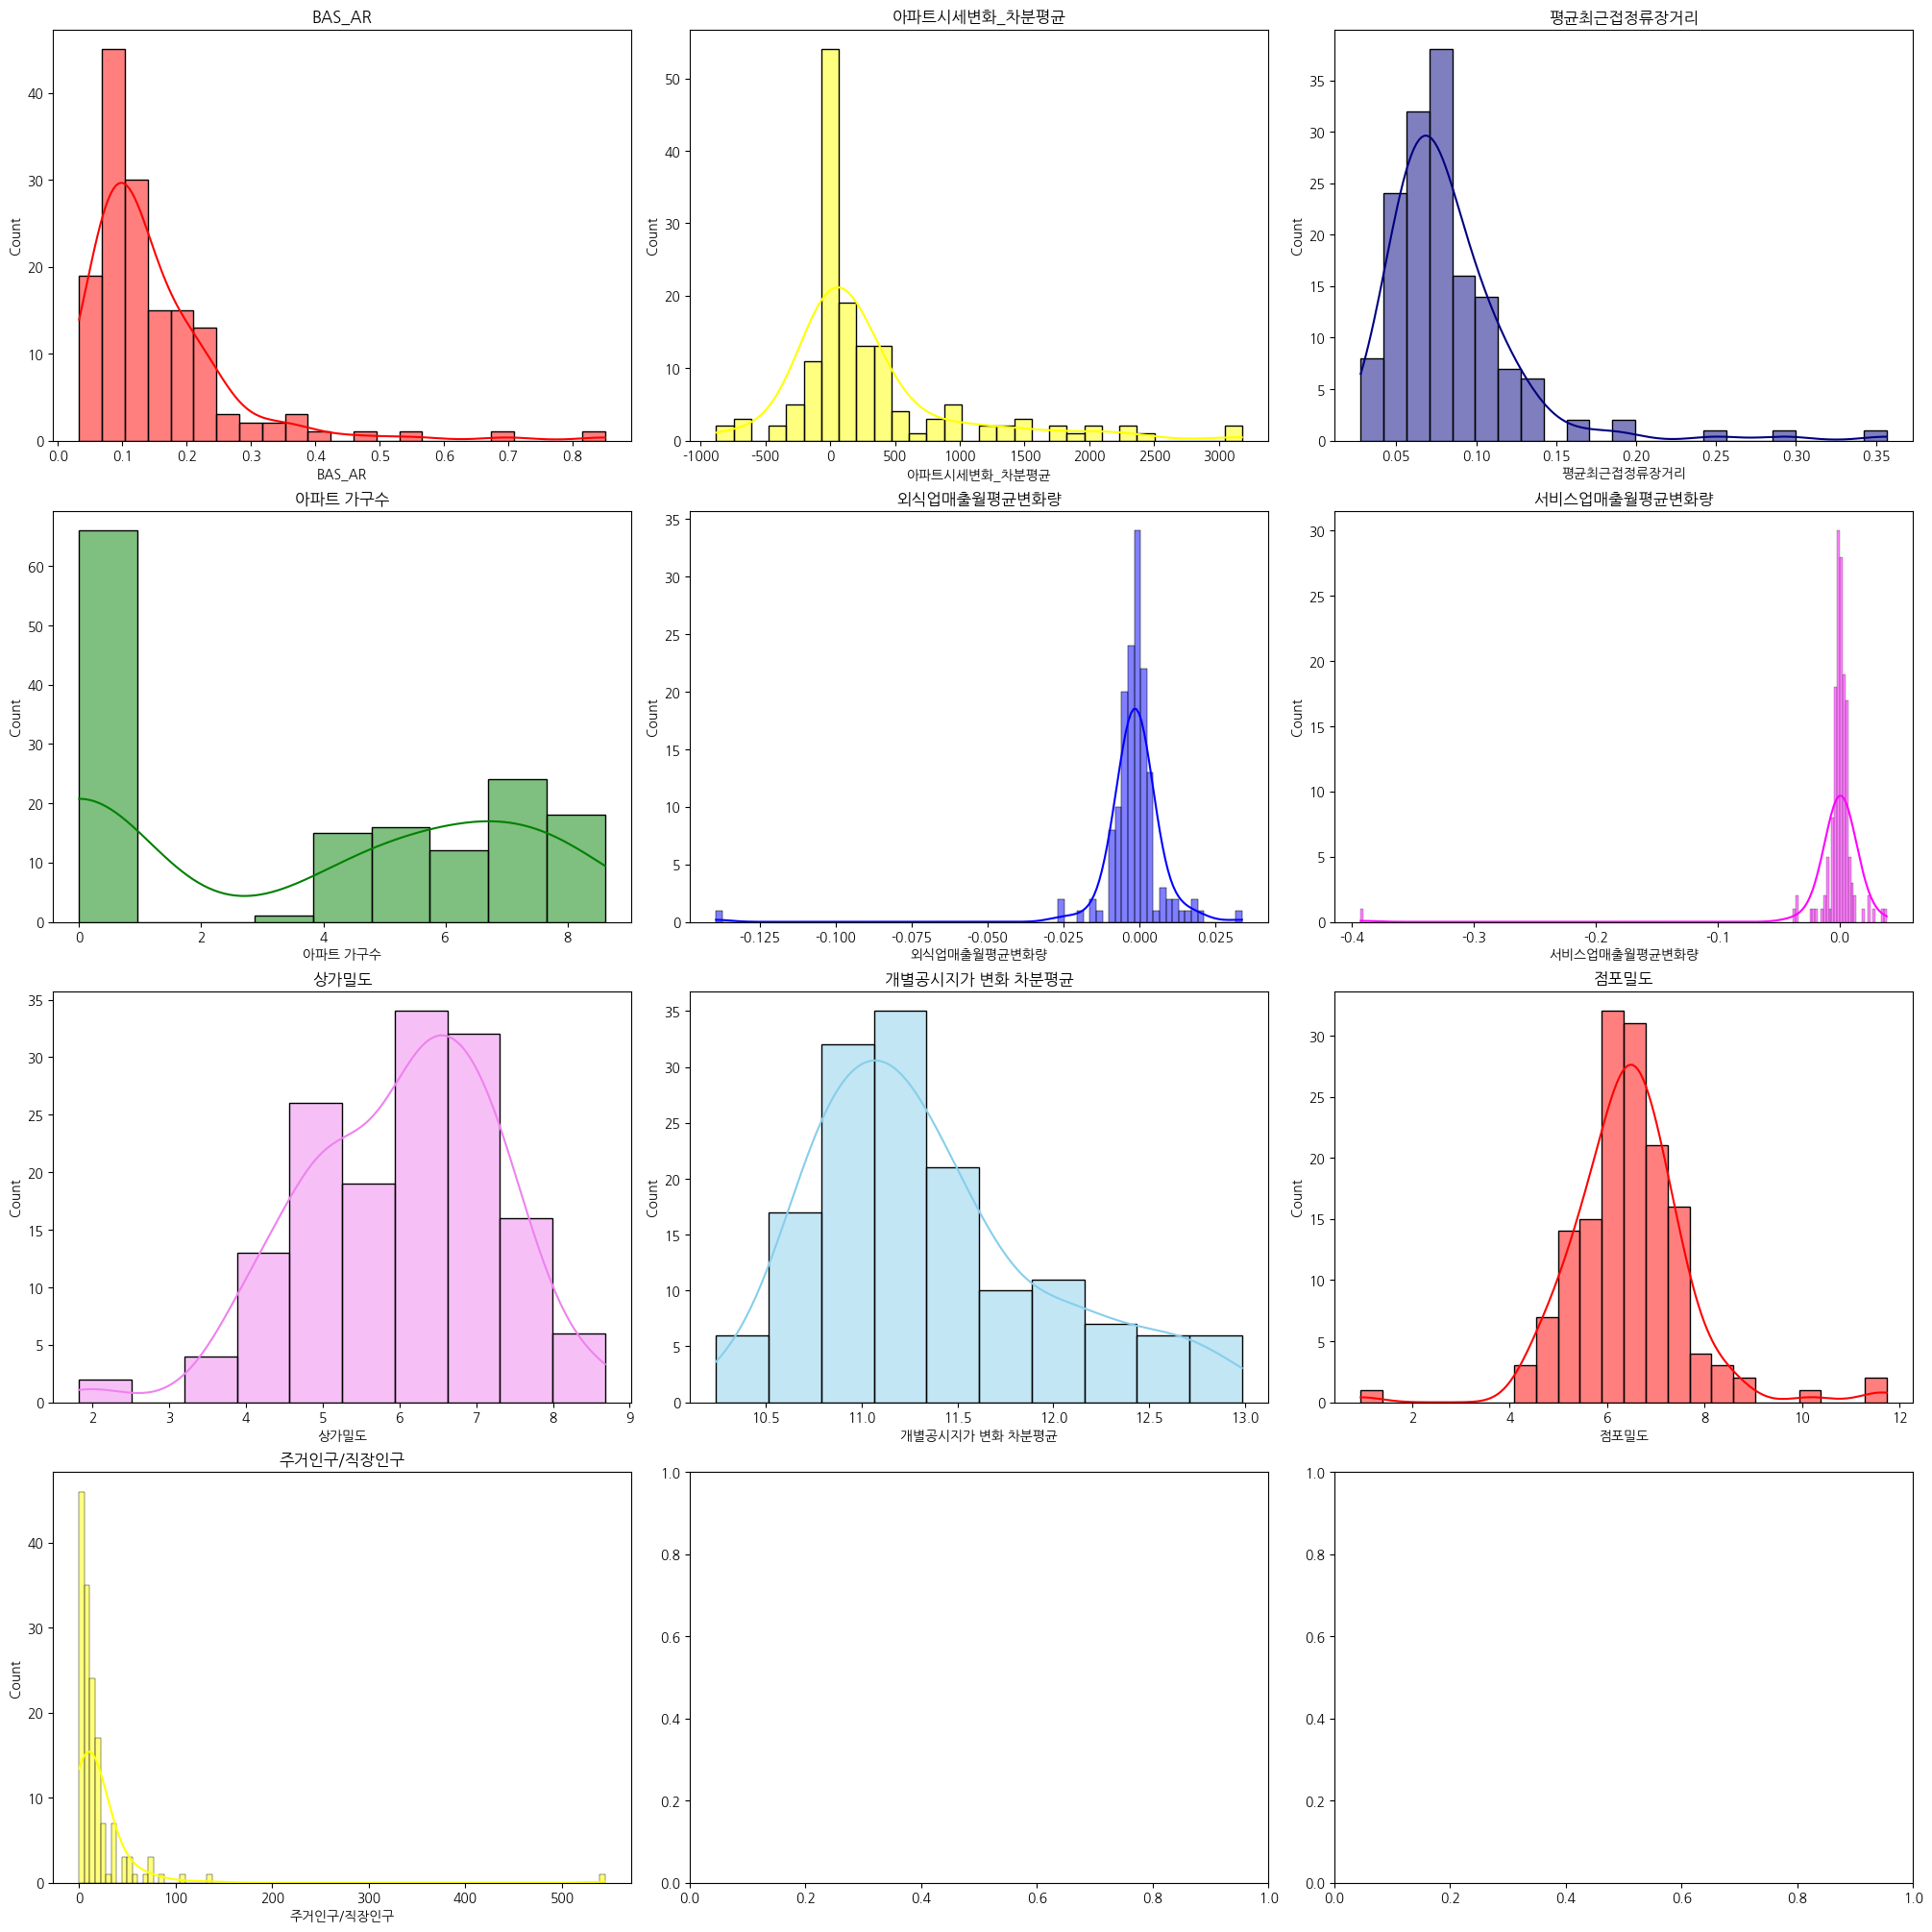

In [88]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,20),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=scaled_dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
        
plt.show()

#### 5.2.1.2 Remodeling

In [103]:
scaled_dX.isnull().sum()

BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 연면적 비율            0
근린생활시설 연면적 비율          0
단독주택 연면적 비율            0
아파트 가구수                0
외식업매출월평균변화량            0
서비스업매출월평균변화량           0
소매업매출월평균변화량            0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말 비율             0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         1
점포밀도                   0
(주거인구+직장인구)/유동인구       0
주거인구/직장인구              0
dtype: int64

In [102]:
# 스케일링된 독립변수 설정.
s_X = scaled_dX.values

# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

Exception: one or more input arrays have missing/NaN values

In [ ]:
gwr_results.summary()

#### 5.2.1.5 Standard Scaling

In [55]:
scaler = StandardScaler()
ss_scaled_dX = scaled_dX.copy()
ss_scaled_dX = pd.DataFrame(scaler.fit_transform(ss_scaled_dX),columns=ss_scaled_dX.columns)
s_X = ss_scaled_dX.values

In [56]:
# 스케일링 후 다중공선성 제거

vif_result = RFE(ss_scaled_dX)
scaled_optimal_feature = vif_result['features'].values.tolist()
scaled_optimal_feature

['아파트시세변화_차분평균',
 '외식업매출월평균변화량',
 '소매업매출월평균변화량',
 '서비스업매출월평균변화량',
 '기초구역평균_전체통합도',
 '평균최근접역거리',
 '건물노후도',
 '주중 / 주말 비율',
 '도로길이고려_국부통합도_R3',
 '개별공시지가 변화 차분평균',
 '평균최근접정류장거리',
 '외식업종다양성',
 '평균 도로 길이',
 '기초구역평균_국부통합도_R3',
 '(주거인구+직장인구)/유동인구',
 '단독주택 연면적 비율',
 '도로율',
 '06 to 18 / 18 to 06',
 '소매업종다양성',
 '서비스업종다양성',
 '아파트 가구수',
 '서비스업매출비율',
 '점포밀도',
 'BAS_AR',
 '근린생활시설 연면적 비율',
 '외식업매출비율',
 '주거인구/직장인구',
 '공동주택 연면적 비율',
 '소매업매출비율']

#### 5.2.1.6 Remodeling

In [57]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

157.0


In [58]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    32

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          66361.174
Log-likelihood:                                                    -701.374
AIC:                                                               1466.748
AICc:                                                              1486.844
BIC:                                                              65723.287
R2:                                                                   0.540
Adj. R2:                                                              0.427

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5.2.2 교차검증

In [65]:
def cross_validation_gwr(lX, ly, kernel,ran_state):
    train_aic = np.zeros(5)
    train_ll = np.zeros(5)
    train_r2 = np.zeros(5)
    train_adj_r2 = np.zeros(5)
    residual = []

    cv = KFold(5, shuffle=True, random_state=ran_state)

    for i, (idx_train, idx_test) in enumerate(cv.split(X = lX, y = ly)):
    
#         print('====================== FOLD {} ======================'.format(i))
        # train, test split
        local_res = np.zeros(158)
        local_X_train, local_y_train = lX[idx_train], ly[idx_train]
        local_u_train = clean_data.iloc[idx_train]['x']
        local_v_train = clean_data.iloc[idx_train]['y']
        local_train_coords = list(zip(local_u_train,local_v_train))
    
        local_X_test, local_y_test = lX[idx_test], ly[idx_test]
        local_u_test = clean_data.iloc[idx_test]['x']
        local_v_test = clean_data.iloc[idx_test]['y']
        local_test_coords = list(zip(local_u_test,local_v_test))
    
        # 모델 생성
        gwr_selector = Sel_BW(local_train_coords, local_y_train, local_X_train,kernel=kernel,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
#         print('BAND WIDTH : {}'.format(gwr_bw))
        gwr_model = GWR(local_train_coords, local_y_train, local_X_train, gwr_bw,kernel=kernel,spherical=True)
        gwr_results = gwr_model.fit()
        
        # Prediction
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        pred_results = gwr_model.predict(np.array(local_test_coords), local_X_test, scale, residuals)
        pred = pred_results.predictions.flatten()
        
        # AIC
        train_aic[i] = gwr_results.aic
    
        # R2 스코어
        train_r2[i] = gwr_results.R2
        
        # Adj. R2 스코어
        train_adj_r2[i] = gwr_results.adj_R2
#         test_r2[i] = r2_score(local_y_test,pred)
        
        # Log-Likelihood
        train_ll[i] = gwr_results.llf
#         residual.append(local_y_test.flatten()-pred)
#         train_rmse[i] = np.sqrt(gwr_results.)
#         test_rmse[i] = np.sqrt(mean_squared_error(local_y_test,pred))
    
#         print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2[i], test_r2[i]))
# #         print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse[i], test_rmse[i]))
#         print("TRAIN AIC : {:.8f}".format(train_aic[i]))
#         print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll[i]))
    
#     print('\n===================== 평균 결과 ======================')
#     print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2.mean(), test_r2.mean()))
# #     print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse.mean(), test_rmse.mean()))
#     print("TRAIN AIC : {:.8f}".format(train_aic.mean()))
#     print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll.mean()))
    
    return train_aic.mean(), train_ll.mean(), train_r2.mean(), train_adj_r2.mean()
# , residual

# cross_validation_gwr(s_X, s_y1)

### 5.2.3 Feature Selection

In [73]:
def search_best_model(kernel,ind_val,ran_state,i):
    flag = True
    min_aic = float('inf')
    max_ll = float('-inf')
    max_r2 = float('-inf')
    adj_r2 = ''
    col_list = list(ind_val.columns)
    drop_col = []

    # flag가 False라면 탈출
    while flag :  
        # 조건 초기화, 평가 치표가 업데이트 된 흔적이 있으면 다시 진입할 것이다.
        flag = False 
    
        # 사용 컬럼 업데이트
#         print('COL LIST COUNT : {}'.format(len(col_list)-len(drop_col)))
#         print('DROP COLUMN LIST COUNT : {}'.format(len(drop_col)))
        col_list = list(set(col_list) - set(drop_col))
        drop_col.clear()
    
        # 사용할 독립변수 업데이트
        temp_dX = ind_val.loc[:,col_list]
    
        # 컬럼 하나씩 지우면서 평가지표 확인
#         for col in tqdm(col_list):
        for col in col_list:
            local_X = temp_dX.drop(col,axis=1).values
            new_aic, new_ll, new_r2, new_adj_r2 = cross_validation_gwr(local_X, s_y1,kernel,ran_state)

            # 새로운 aic는 기존의 aic보다 작고, 새로운 ll은 기존의 ll보다 큰가?(AND 조건이어야 함.)
            if (new_aic < min_aic) & (new_ll > max_ll) & (max_r2 < new_r2):
                min_aic = new_aic
                max_ll = new_ll
                max_r2 = new_r2
                adj_r2 = new_adj_r2
                drop_col.append(col)
                flag = True
#                 print('========================= NEW VALIDATION =========================')
#                 print('NEW MAX R2 : {:.8f}'.format(max_r2))
#                 print('NEW MIN AIC : {:.8f}'.format(min_aic))
#                 print('NEW MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    
    print('========================= RESULT =========================')
    print('KERNEL : {}'.format(kernel))
    print('RANDOM STATE : {}'.format(ran_state))
    print('DATASET NUMBER : {}'.format(i))
    print('MAX R2 : {:.8f}'.format(max_r2))
    print('Adj. R2 : {:.8f}'.format(adj_r2))
    print('MIN AIC : {:.8f}'.format(min_aic))
    print('MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    print('COLUMN COUNT : {}'.format(len(col_list)))
#     print('COLUMN : {}'.format(col_list))

    
    result = pd.DataFrame({'KERNEL':kernel,'RANDOM STATE':ran_state,'DATASET NUMBER':i,'R2':max_r2
                           ,'Adj. R2':adj_r2,'AIC':min_aic,'LOG LIKELIHOOD':max_ll
                           ,'COLUMN COUNT':len(col_list),'COLUMN':[col_list]})
    
    return result

In [74]:
remove_vif_dX = dX.loc[:,optimal_feature].copy() # 다중공선성 제거
not_remove_vif_dX = dX.copy() # 다중공선성 제거 X

list_df = [remove_vif_dX, not_remove_vif_dX]
kernel = ['gaussian','bisquare','exponential']
random_state = [10,50,100,500,1000]

conclusion = pd.DataFrame()
count = 0

for k in kernel:
    for i, df in enumerate(list_df):
        for rs in random_state:
            result = search_best_model(k,df,rs,i)
            conclusion= pd.concat([conclusion,result],axis=0,ignore_index=True)
            count += 1
            print('진행률 : {:.2f}%'.format(count/(len(kernel)*len(list_df)*len(random_state))*100))         

conclusion.head()

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 10
다중공선성 제거 유무 : O
MIN AIC : 1222.99938557
MAX LOG-LIKELIHOOD : -587.39298975
COLUMN COUNT : 14
진행률 : 3.33%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 50
다중공선성 제거 유무 : O
MIN AIC : 1222.12077647
MAX LOG-LIKELIHOOD : -586.94030057
COLUMN COUNT : 15
진행률 : 6.67%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 100
다중공선성 제거 유무 : O
MIN AIC : 1220.73818939
MAX LOG-LIKELIHOOD : -586.41239038
COLUMN COUNT : 14
진행률 : 10.00%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 500
다중공선성 제거 유무 : O
MIN AIC : 1223.02347591
MAX LOG-LIKELIHOOD : -587.67427862
COLUMN COUNT : 13
진행률 : 13.33%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 1000
다중공선성 제거 유무 : O
MIN AIC : 1221.41360366
MAX LOG-LIKELIHOOD : -585.88090871
COLUMN COUNT : 12
진행률 : 16.67%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 10
다중공선성 제거 유무 : X
MIN AIC : 1220.25077755
MAX LOG-LIKELIHOOD : -575.90146560
COLUMN COUNT : 26
진행률 : 20.00%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 50
다중공선성 제거 유무 : X
MIN AIC : 1219.54629835
MAX LOG-LIKELIHOOD : -575.42003941
COLUMN COUNT : 28
진행률 : 23.33%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 100
다중공선성 제거 유무 : X
MIN AIC : 1219.07117115
MAX LOG-LIKELIHOOD : -575.05272948
COLUMN COUNT : 27
진행률 : 26.67%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 500
다중공선성 제거 유무 : X
MIN AIC : 1219.48664950
MAX LOG-LIKELIHOOD : -575.35218403
COLUMN COUNT : 26
진행률 : 30.00%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 1000
다중공선성 제거 유무 : X
MIN AIC : 1222.89468843
MAX LOG-LIKELIHOOD : -577.17139047
COLUMN COUNT : 25
진행률 : 33.33%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 10
다중공선성 제거 유무 : O
MIN AIC : 1216.19142872
MAX LOG-LIKELIHOOD : -577.87464345
COLUMN COUNT : 14
진행률 : 36.67%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 50
다중공선성 제거 유무 : O
MIN AIC : 1212.16043169
MAX LOG-LIKELIHOOD : -574.00390777
COLUMN COUNT : 15
진행률 : 40.00%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 100
다중공선성 제거 유무 : O
MIN AIC : 1213.66602672
MAX LOG-LIKELIHOOD : -576.07280961
COLUMN COUNT : 14
진행률 : 43.33%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 500
다중공선성 제거 유무 : O
MIN AIC : 1215.31275280
MAX LOG-LIKELIHOOD : -577.07189690
COLUMN COUNT : 15
진행률 : 46.67%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 1000
다중공선성 제거 유무 : O
MIN AIC : 1210.61818851
MAX LOG-LIKELIHOOD : -572.36250575
COLUMN COUNT : 15
진행률 : 50.00%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 10
다중공선성 제거 유무 : X
MIN AIC : 1208.15214155
MAX LOG-LIKELIHOOD : -556.16394275
COLUMN COUNT : 27
진행률 : 53.33%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 50
다중공선성 제거 유무 : X
MIN AIC : 1205.98403287
MAX LOG-LIKELIHOOD : -555.75888780
COLUMN COUNT : 28
진행률 : 56.67%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 100
다중공선성 제거 유무 : X
MIN AIC : 1205.39200384
MAX LOG-LIKELIHOOD : -554.63055014
COLUMN COUNT : 28
진행률 : 60.00%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 500
다중공선성 제거 유무 : X
MIN AIC : 1206.32186758
MAX LOG-LIKELIHOOD : -555.93738174
COLUMN COUNT : 28
진행률 : 63.33%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : bisquare
RANDOM STATE : 1000
다중공선성 제거 유무 : X
MIN AIC : 1209.34725873
MAX LOG-LIKELIHOOD : -555.39851346
COLUMN COUNT : 25
진행률 : 66.67%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 10
다중공선성 제거 유무 : O
MIN AIC : 1221.81378906
MAX LOG-LIKELIHOOD : -584.65720852
COLUMN COUNT : 14
진행률 : 70.00%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 50
다중공선성 제거 유무 : O
MIN AIC : 1220.14844378
MAX LOG-LIKELIHOOD : -583.68691348
COLUMN COUNT : 14
진행률 : 73.33%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 100
다중공선성 제거 유무 : O
MIN AIC : 1219.01135811
MAX LOG-LIKELIHOOD : -582.35096380
COLUMN COUNT : 15
진행률 : 76.67%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 500
다중공선성 제거 유무 : O
MIN AIC : 1220.73940973
MAX LOG-LIKELIHOOD : -583.88810890
COLUMN COUNT : 14
진행률 : 80.00%


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 1000
다중공선성 제거 유무 : O
MIN AIC : 1214.81933070
MAX LOG-LIKELIHOOD : -583.10079670
COLUMN COUNT : 13
진행률 : 83.33%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 10
다중공선성 제거 유무 : X
MIN AIC : 1211.99339726
MAX LOG-LIKELIHOOD : -564.76906279
COLUMN COUNT : 27
진행률 : 86.67%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 50
다중공선성 제거 유무 : X
MIN AIC : 1210.27080698
MAX LOG-LIKELIHOOD : -563.00319070
COLUMN COUNT : 27
진행률 : 90.00%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 100
다중공선성 제거 유무 : X
MIN AIC : 1210.79557558
MAX LOG-LIKELIHOOD : -563.85173892
COLUMN COUNT : 26
진행률 : 93.33%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 500
다중공선성 제거 유무 : X
MIN AIC : 1210.55287046
MAX LOG-LIKELIHOOD : -563.88206212
COLUMN COUNT : 26
진행률 : 96.67%


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

========================= RESULT =========================
KERNEL : exponential
RANDOM STATE : 1000
다중공선성 제거 유무 : X
MIN AIC : 1214.37885140
MAX LOG-LIKELIHOOD : -565.91773197
COLUMN COUNT : 26
진행률 : 100.00%


,KERNEL,RANDOM STATE,다중공선성 제거 유무,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
0,gaussian,10,O,1222.999386,-587.392990,14,"[상가밀도, 근린생활시설 연면적 비율, 점포밀도, 평균 도로 길이, BAS_AR, ..."
1,gaussian,50,O,1222.120776,-586.940301,15,"[점포밀도, 공동주택 연면적 비율, BAS_AR, INT_LOAD_R3, BUILD..."
2,gaussian,100,O,1220.738189,-586.412390,14,"[상가밀도, 근린생활시설 연면적 비율, 점포밀도, 평균 도로 길이, BAS_AR, ..."
3,gaussian,500,O,1223.023476,-587.674279,13,"[상가밀도, 근린생활시설 연면적 비율, 평균 도로 길이, BAS_AR, 평균최근접역..."
4,gaussian,1000,O,1221.413604,-585.880909,12,"[상가밀도, 근린생활시설 연면적 비율, 점포밀도, 평균 도로 길이, BAS_AR, ..."


In [75]:
condition = (conclusion['AIC'] == conclusion['AIC'].min()) | (conclusion['LOG LIKELIHOOD'].max() == conclusion['LOG LIKELIHOOD'])
conclusion[condition]

,KERNEL,RANDOM STATE,다중공선성 제거 유무,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
17,bisquare,100,X,1205.392004,-554.63055,28,"[APART_DIFF_AVG, 공동주택 연면적 비율, 도로율, BAS_AR, 외식업..."


In [76]:
conclusion.to_csv('../data/최적모델평가지표(평균폐업기간,폐업없음 제거).csv',encoding='euc-kr',index=False)

#### 5.2.3.1 Remodeling
- 위의 검증 결과 중 가장 좋은 모델 성능을 보이는 컬럼을 기준으로 모델을 돌려본다.

In [77]:
# kernel : bisquare
# 다중공선성 제거 X

col = conclusion.iloc[17]['COLUMN']

s_X = dX.loc[:,col].values

In [78]:
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='bisquare',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='bisquare',spherical=True)
gwr_results = gwr_model.fit()

151.0


In [ ]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+col
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균폐업기간,BEST).csv',encoding='euc-kr',index=False)

In [79]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 152
Number of covariates:                                                    29

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       12979739.987
Log-likelihood:                                                   -1078.660
AIC:                                                               2215.320
AICc:                                                              2236.273
BIC:                                                           12979122.049
R2:                                                                 -51.050
Adj. R2:                                                            -62.899

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## 5.3 Dataset별 GWR Modeling

In [1124]:
# 1. Raw Data
rd_X = clean_data.iloc[:,ind_var_col]

# 2. Raw Data에서 다중공선성 제거
remove_high_vif_X = clean_data.loc[:,optimal_feature]

# 3. skew가 2 이상인 데이터에 대해서 log1p를 적용한 데이터셋+standard scaler
scaled_X = ss_scaled_dX

# 4. skew가 2 이상인 데이터에 대해서 log1p를 적용하고 다중공선성을 제거한 데이터셋
remove_high_vif_scaled_X = ss_scaled_dX.loc[:,scaled_optimal_feature]

# 5. Raw Data에서 매출월평균변화량만 제거
rm_avg_X = clean_data.iloc[:,ind_var_col].drop(['서비스업매출월평균변화량','소매업매출월평균변화량','외식업매출월평균변화량'],axis=1)

# 6.skew가 2 이상인 데이터에 대해서 log1p를 적용하고 +standard~ 매출월평균변화량만 제거
scaled_rm_avg_X = ss_scaled_dX.drop(['서비스업매출월평균변화량','소매업매출월평균변화량','외식업매출월평균변화량'],axis=1)

ind_dataset = [rd_X,remove_high_vif_X,scaled_X,remove_high_vif_scaled_X,rm_avg,scaled_rm_avg_X]
kernel = ['gaussian','exponential','bisquare']

aic = []
ll = []
r2 = []
adj_r2 = []
ker = []
dataset_idx = []

for func in kernel:
    for i,s_X in enumerate(ind_dataset):
        s_X = s_X.values
        # 모델 생성
        gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=func,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
        gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel=func,spherical=True)
        gwr_results = gwr_model.fit()
    
        # 평가 지표
        aic.append(gwr_results.aic)
        ll.append(gwr_results.llf)
        r2.append(gwr_results.R2)
        adj_r2.append(gwr_results.adj_R2)
        ker.append(func)
        dataset_idx.append(i)

valid_result = pd.DataFrame({'Data Number':dataset_idx,'Kernel':ker,'R2':r2,'Adj. R2':adj_r2
                             ,'AIC':aic,'Log-Likelihood':ll})

In [1125]:
valid_result.sort_values(by='R2',ascending=False)

,Data Number,Kernel,R2,Adj. R2,AIC,Log-Likelihood
17,5,bisquare,0.667896,0.503376,1457.442903,-675.711056
8,2,exponential,0.664195,0.511899,1453.146429,-676.586609
12,0,bisquare,0.642062,0.485474,1460.819118,-681.629130
16,4,bisquare,0.639419,0.500037,1453.958981,-682.210252
14,2,bisquare,0.639367,0.479707,1462.799108,-682.221605
11,5,exponential,0.638875,0.503710,1452.177102,-682.329263
15,3,bisquare,0.635631,0.486995,1459.048962,-683.035756
6,0,exponential,0.619308,0.480019,1459.107857,-686.497895
9,3,exponential,0.616360,0.485605,1456.030871,-687.107370
10,4,exponential,0.615308,0.491040,1453.313522,-687.323735


### 5.3.1 Feature Selection

In [981]:
import time

list_df = ind_dataset
kernel = ['gaussian','bisquare','exponential']
random_state = [10]

conclusion = pd.DataFrame()
count = 0
start_time = time.time()

for k in kernel:
    for i, df in enumerate(list_df):
        for rs in random_state:
            result = search_best_model(k,df,rs,i)
            conclusion= pd.concat([conclusion,result],axis=0,ignore_index=True)
            count += 1
            print('진행률 : {0:.2f}%, 소요시간 : {1:.2f}분'.format(count/(len(kernel)*len(list_df)*len(random_state))*100,(time.time()-start_time)/60))

conclusion.head()

========================= RESULT =========================
KERNEL : gaussian
RANDOM STATE : 10
DATASET NUMBER : 0
MAX R2 : 0.59347492
Adj. R2 : 0.44644686
MIN AIC : 1174.45460108
MAX LOG-LIKELIHOOD : -552.91017770
COLUMN COUNT : 27
진행률 : 5.56%, 소요시간 : 1.10분


KeyboardInterrupt: 

In [410]:
# kernel : gaussian
# 다중공선성 제거 O

col = conclusion.iloc[18,6]

# conclusion.iloc[18,6]

# s_X = clean_data.loc[:,col].values

s_X = ss_scaled_data.loc[:,col].values

NameError: name 'ss_scaled_data' is not defined

In [356]:
gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel='exponential',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='exponential',spherical=True)
gwr_results = gwr_model.fit()

18.0


In [409]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+col
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균영업기간_BEST_New_Data).csv',encoding='euc-kr',index=False)

ValueError: Length mismatch: Expected axis has 32 elements, new values have 8 elements

In [357]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         105804.032
Log-likelihood:                                                    -738.225
AIC:                                                               1492.451
AICc:                                                              1495.667
BIC:                                                             105044.643
R2:                                                                   0.267
Adj. R2:                                                              0.233

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [741]:
condition = (conclusion['AIC'] == conclusion['AIC'].min()) | (conclusion['LOG LIKELIHOOD'] == conclusion['LOG LIKELIHOOD'].max())
conclusion[condition]

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
6,bisquare,10,2,0.745798,0.553184,1044.74461,-456.493993,28,"[도로율, 소매업매출비율, 서비스업매출월평균변화량, 점포밀도, 도로길이고려_전체통합..."


In [908]:
condition = ((conclusion['AIC'].min() == conclusion['AIC']) | (conclusion['LOG LIKELIHOOD'].max() == conclusion['LOG LIKELIHOOD']) 
             | (conclusion['R2'] == conclusion['R2'].max()))
conclusion[condition]

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
8,bisquare,10,2,0.749293,0.58519,-347.859165,239.980726,27,"[평균 도로 길이, 소매업매출비율, 점포밀도, 도로길이고려_전체통합도, 평균최근접정..."
11,bisquare,10,5,0.783425,0.57970,1060.818802,-462.454151,24,"[평균 도로 길이, 소매업매출비율, 점포밀도, 평균최근접정류장거리, 공동주택 연면적..."


In [909]:
conclusion.sort_values(by='LOG LIKELIHOOD',ascending=False).head()

,KERNEL,RANDOM STATE,DATASET NUMBER,R2,Adj. R2,AIC,LOG LIKELIHOOD,COLUMN COUNT,COLUMN
8,bisquare,10,2,0.749293,0.585190,-347.859165,239.980726,27,"[평균 도로 길이, 소매업매출비율, 점포밀도, 도로길이고려_전체통합도, 평균최근접정..."
11,bisquare,10,5,0.783425,0.579700,1060.818802,-462.454151,24,"[평균 도로 길이, 소매업매출비율, 점포밀도, 평균최근접정류장거리, 공동주택 연면적..."
14,exponential,10,2,0.699977,0.527606,1160.646674,-533.555926,28,"[소매업매출비율, 서비스업매출월평균변화량, 점포밀도, 도로길이고려_전체통합도, 평균..."
17,exponential,10,5,0.697164,0.541678,1155.345500,-533.956623,24,"[평균 도로 길이, 소매업매출비율, 점포밀도, 도로길이고려_전체통합도, 평균최근접정..."
6,bisquare,10,0,0.692876,0.517285,1163.476384,-535.126250,27,"[소매업매출비율, 점포밀도, 도로길이고려_전체통합도, 평균최근접정류장거리, 공동주택..."


#### 5.3.1.1 Remodeling

In [1135]:
idx = 5
kernel = 'bisquare'
# conclusion.iloc[idx]['KERNEL']
col = ['평균 도로 길이', '소매업매출비율', '점포밀도', '평균최근접정류장거리', '공동주택 연면적 비율', '서비스업매출비율', '06 to 18 / 18 to 06', 'BAS_AR', '기초구역평균_국부통합도_R3', '평균최근접역거리', '개별공시지가 변화 차분평균', '서비스업종다양성', '외식업매출비율', '(주거인구+직장인구)/유동인구', '주중 / 주말 비율', '주거인구/직장인구', '기초구역평균_전체통합도', '소매업종다양성', '근린생활시설 연면적 비율', '아파트시세변화_차분평균', '아파트 가구수', '상가밀도', '외식업종다양성', '단독주택 연면적 비율']


# conclusion.iloc[idx]['COLUMN']

s_X = ind_dataset[idx].loc[:,col].values
# s_X = ind_dataset[conclusion.iloc[idx]['DATASET NUMBER']].loc[:,col].values

In [1136]:
#Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=kernel,spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel=kernel,spherical=True)
gwr_results = gwr_model.fit()

139.0


In [1138]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 158
Number of covariates:                                                    25

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          78568.720
Log-likelihood:                                                    -714.714
AIC:                                                               1479.428
AICc:                                                              1488.859
BIC:                                                              77895.395
R2:                                                                   0.456
Adj. R2:                                                              0.358

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [1020]:
conclusion.to_csv('../data/최적모델평가지표(평균영업기간,new_data(자동차유지,10퍼센트절사평균))).csv',encoding='euc-kr',index=False)

PermissionError: [Errno 13] Permission denied: '../data/최적모델평가지표(평균영업기간,new_data(자동차유지,10퍼센트절사평균))).csv'

# 6. 군집별 회귀분석

## 6.1 군집 데이터 로딩

In [ ]:
sds_cluster = pd.read_csv('../data/군집화 결과/sds_cluster.csv')
sds_cluster.head()

In [ ]:
sds_cluster['BAS_ID']= sds_cluster['BAS_ID'].astype(str)

1. 각 클러스터 기준에 따라서, 각 군집별로 회귀 모델을 생성.
2. 각 모델별로 회귀계수 dataframe 생성

## 6.2 평균영업기간(7개 군집)

In [ ]:
temp_df = sds_cluster[['BAS_ID','open_7cluster_sds']]
open_cluster_7 = clean_data.merge(temp_df,how='inner',right_on='BAS_ID',left_on='BAS_ID')

## 6.3 군집별 GWR 모델링

In [ ]:
ind_var_col = list(range(1,9)) + list(range(11,34))

s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2
# s_X = clean_data.iloc[:,ind_var_col].drop(scale_factor,axis=1).values # 다중공선성이 있는 column들은 제거
s_X = clean_data.iloc[:,ind_var_col].values
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

### 6.3.1 종속변수, 독립변수 설정

In [ ]:
# 독립변수, 종속변수 설정
# 이전에 모델 생성에 있어서 가장 성능이 좋았던 컬럼들을 이용하자.
s_X = pd.concat([open_cluster_7.iloc[:,ind_var_col],open_cluster_7.loc[:,'open_7cluster_sds']],axis=1)
s_X = s_X
s_y1 = open_cluster_7['평균폐업기간'].values.reshape((-1,1))
u = open_cluster_7['x'] # 경도
v = open_cluster_7['y'] # 위도
s_coords = list(zip(u,v))

### 6.3.2 군집별 모델 생성

In [ ]:
# 군집 리스트 생성
cluster_list = open_cluster_7['open_7cluster_sds'].unique()

# 군집별 모델 생성
for cluster in cluster_list:
    

# 7. T-검정

In [80]:
# 필요 데이터셋 생성
s_X = pd.concat([dX.loc[:,col],clean_data.loc[:,['x','y']]],axis=1)

# train, test split
X_train, X_test, y_train, y_test = train_test_split(s_X, s_y2, test_size=0.2, shuffle=True,random_state=34)

# train 좌표 생성
u_train = X_train.loc[:,'x']
v_train = X_train.loc[:,'y']
train_coords = list(zip(u_train,v_train))

# test 좌표 생성
u_test = X_test.loc[:,'x']
v_test = X_test.loc[:,'y']
test_coords = list(zip(u_test,v_test))

# train, test set 독립변수 리스트에서 좌표 제거
X_train.drop(['x','y'],axis=1,inplace=True)
X_test.drop(['x','y'],axis=1,inplace=True)

X_train = X_train.values
X_test = X_test.values

# 모델 생성
gwr_selector = Sel_BW(train_coords, y_train, X_train,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)

print('BAND WIDTH : {}'.format(gwr_bw))
gwr_model = GWR(train_coords, y_train, X_train, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()
    
# Prediction
scale = gwr_results.scale
residuals = gwr_results.resid_response
pred_results = gwr_model.predict(np.array(test_coords), X_test, scale, residuals)
pred = pred_results.predictions.flatten() 

BAND WIDTH : 119.0


In [83]:
# 독립이표본 t-test
result = stats.ttest_ind(pred, y_test, equal_var=False)
print('p-value : {:.8f}'.format(result[1][0]))

# 유의 수준 0.05에서 귀무가설을 기각할 수 없으므로 두 집단 간의 평균 차이가 없다고 말할 수 있다.

p-value : 0.48513354
